# Route time estimator

## Libraries

In [401]:
from typing import Any, Dict, List, Tuple, Optional
from dataclasses import dataclass

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from geopy.distance import geodesic

import requests
from requests.adapters import HTTPAdapter

## Utility

In [402]:
RANDOM_STATE: int = 23

np.random.seed(RANDOM_STATE)

In [403]:
def plot_history(history):

    metrics = ["loss", "mean_absolute_error", "mean_squared_error",
               "root_mean_squared_error", "mean_absolute_percentage_error"]
    metric_labels = ["Loss", "MAE", "MSE", "RMSE", "MAPE"]

    plt.figure(figsize=(15, 10))

    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        plt.subplot(2, 3, i + 1)  # Arrange in a 2x3 grid
        plt.plot(history.history[metric], label=f'Train {label}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {label}')
        plt.xlabel('Epochs')
        plt.ylabel(label)
        plt.title(f'{label} History')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [404]:
def mean_signed_deviation_percentage(y_true: np.ndarray, y_pred: np.ndarray) -> np.float32:
    return np.mean((y_pred - y_true) / y_true)

mean_signed_deviation_percentage(np.array([1, 2, 3]), np.array([2, 2, 2]))

np.float64(0.22222222222222224)

In [405]:
import os
import json

RESULTS_PATH: str = './results/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

VERSION: str = 'v2'
VERSION_PATH: str = os.path.join(RESULTS_PATH, VERSION)

if not os.path.exists(VERSION_PATH):
    os.makedirs(VERSION_PATH)

METRICS_PATH: str = os.path.join(VERSION_PATH, 'metrics')
if not os.path.exists(METRICS_PATH):
    os.makedirs(METRICS_PATH)

PLOT_PATH: str = os.path.join(VERSION_PATH, 'plots')
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

MODEL_PATH: str = os.path.join(VERSION_PATH, 'models')
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [406]:
AUGMENT_DATA = True
AUGMENTATION_ITER = 1
AUGMENTATION_PROB = 1.0

## Data

In [407]:
DATA_PATH = 'C:/Users/volpato/OneDrive - Cefriel/Desktop/P/FAE/db/'

### Shipments

In [408]:
orders_df = pd.read_csv(DATA_PATH + 'order.csv')
orders_df.head()

,id,manufacturer_id,manufacturer_order_id,site_id,carrier_id,status,n_steps,tracking_link,tracking_number,manufacturer_creation_timestamp,manufacturer_estimated_delivery_timestamp,manufacturer_confirmed_delivery_timestamp,carrier_creation_timestamp,carrier_estimated_delivery_timestamp,carrier_confirmed_delivery_timestamp,SLS,SRS
0,1,1,6004,8,1,DELIVERED,14,https://mydhl.express.dhl/it/it/tracking.html#...,1656325344,2025-01-07 07:31:00+00:00,2025-01-13 22:00:00+00:00,2025-01-17 11:36:00+00:00,2025-01-14T17:16+08:00,NaN,2025-01-17 10:40:00+00:00,0,0
1,2,1,6005,1,2,DELIVERED,11,1Z60699Y0400391867,1Z60699Y0400391867,2025-01-07 13:57:00+00:00,2025-01-08 22:00:00+00:00,2025-01-13 12:47:00+00:00,2025-01-09T03:11+00:00,NaN,2025-01-13 09:19:00+00:00,0,0
2,3,1,6037,3,2,DELIVERED,11,1ZR465910413218509,1ZR465910413218509,2025-01-10 13:41:00+00:00,2025-01-14 22:00:00+00:00,2025-01-15 09:18:00+00:00,2025-01-10T19:10-05:00,NaN,2025-01-15 09:47:00+00:00,0,0
3,4,1,6045,3,2,DELIVERED,12,https://www.digikey.it/OrderHistory/shipmenttr...,1ZR465910413219320,2025-01-13 15:27:00+00:00,2025-01-15 22:00:00+00:00,2025-01-15 09:45:00+00:00,2025-01-13T12:08-05:00,NaN,2025-01-15 09:47:00+00:00,0,0
4,5,1,6046,4,3,DELIVERED,14,https://www.fedex.com/fedextrack/?trknbr=43744...,437446419489,2025-01-13 15:27:00+00:00,2025-01-15 22:00:00+00:00,2025-01-15 12:14:00+00:00,2025-01-13T14:15-06:00,NaN,2025-01-15 11:49:00+00:00,0,0


In [409]:
orders_df.shape

(98, 17)

### Shipments steps

In [410]:
shipments_steps_df = pd.read_csv(DATA_PATH + 'order_steps_enriched.csv')
shipments_steps_df.head()

,order_id,step_source,timestamp_source,location_source,step_destination,timestamp_destination,location_destination,hours,geodesic_km,distance_road_km,time_road_no_traffic_hours,time_road_traffic_hours,wmi,tmi,transportation_mode
0,1,1,2025-01-14 09:16:00+00:00,"DONGGUAN, GUANGDONG, CN",2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",8.400000,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
1,1,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",0.416667,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
2,1,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",3.683333,61.761066,107.745,2.115278,2.115278,0.224436,0.0,ROAD
3,1,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",30.283333,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
4,1,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",6,2025-01-16 23:01:00+00:00,"BRUSSELS, BRUSSELS CAPITAL, BE",18.966667,9381.875452,0.000,0.000000,0.000000,0.750000,0.0,AIR


In [411]:
shipments_steps_df.head()

,order_id,step_source,timestamp_source,location_source,step_destination,timestamp_destination,location_destination,hours,geodesic_km,distance_road_km,time_road_no_traffic_hours,time_road_traffic_hours,wmi,tmi,transportation_mode
0,1,1,2025-01-14 09:16:00+00:00,"DONGGUAN, GUANGDONG, CN",2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",8.400000,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
1,1,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",0.416667,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
2,1,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",3.683333,61.761066,107.745,2.115278,2.115278,0.224436,0.0,ROAD
3,1,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",30.283333,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
4,1,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",6,2025-01-16 23:01:00+00:00,"BRUSSELS, BRUSSELS CAPITAL, BE",18.966667,9381.875452,0.000,0.000000,0.000000,0.750000,0.0,AIR


In [412]:
site_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'site.csv')
site_df.head()

,id,supplier_id,location_name,n_rejections,n_orders,consider_closure_holidays,consider_working_holidays,consider_weekends_holidays
0,1,1,"LEEDS, ENGLAND, GB",0,5,True,True,True
1,2,2,"LOUISVILLE, KENTUCKY, US",0,3,True,True,True
2,3,2,"THIEF RIVER FALLS, MINNESOTA, US",0,61,True,True,True
3,4,3,"GRAND PRAIRIE, TEXAS, US",0,5,True,True,True
4,5,4,"MONTAGNOLA, TICINO, CH",0,1,True,True,True


In [413]:
vertex_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'vertex.csv')
vertex_df.head()

,id,name,type
0,1,"HO CHI MINH CITY, HO CHI MINH, VN",INTERMEDIATE
1,2,"CASTLE DONINGTON, ENGLAND, GB",INTERMEDIATE
2,3,"SHENZHEN, GUANGDONG, CN",INTERMEDIATE
3,4,"ZHUHAI, GUANGDONG, CN",INTERMEDIATE
4,5,"DONGGUAN, GUANGDONG, CN",INTERMEDIATE


In [414]:
ori_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'ori.csv')
ori_df.head()

,id,vertex_id,created_at,hours
0,1,5,2025-08-21T14:05:19+00:00,0.416667
1,2,3,2025-08-21T14:05:19+00:00,30.283333
2,3,33,2025-08-21T14:05:19+00:00,0.016667
3,4,43,2025-08-21T14:05:19+00:00,3.016667
4,5,28,2025-08-21T14:05:19+00:00,1.766667


In [415]:
avg_ori_df = ori_df.groupby('vertex_id')['hours'].mean().reset_index()
avg_ori_df.head()

,vertex_id,hours
0,1,1.416667
1,2,5.791667
2,3,10.050000
3,5,0.416667
4,8,2.733333


In [416]:
oti_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'oti.csv')
oti_df.head()

,id,source_id,destination_id,created_at,hours
0,1,9,5,2025-08-21T14:05:36+00:00,8.400000
1,2,5,3,2025-08-21T14:05:36+00:00,3.683333
2,3,3,33,2025-08-21T14:05:36+00:00,18.966667
3,4,33,43,2025-08-21T14:05:36+00:00,1.983333
4,5,43,28,2025-08-21T14:05:36+00:00,1.450000


In [417]:
oti_dist_df: pd.DataFrame = oti_df.groupby(['source_id', 'destination_id'])['hours'].agg(
    [
        'mean',
        'std',
        ('q1', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('q3', lambda x: x.quantile(0.75)),
        'min',
        'max',
        'count'
    ]).reset_index()    # type: ignore                  

oti_dist_df.head()

,source_id,destination_id,mean,std,q1,median,q3,min,max,count
0,1,32,4.883333,NaN,4.883333,4.883333,4.883333,4.883333,4.883333,1
1,2,39,0.554167,0.442923,0.325000,0.408333,0.637500,0.200000,1.200000,4
2,3,32,2.333333,0.714920,1.820833,2.133333,2.820833,1.583333,3.383333,6
3,3,33,18.966667,NaN,18.966667,18.966667,18.966667,18.966667,18.966667,1
4,4,62,26.916667,NaN,26.916667,26.916667,26.916667,26.916667,26.916667,1


In [418]:
wmi_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'wmi.csv')
wmi_df.head()

,id,source_id,destination_id,timestamp,created_at,n_interpolation_points,step_distance_km,value
0,0,5,3,2025-01-14T21:46+00:00,2025-08-21T14:05:42+00:00,2,200.00000,0.224436
1,1,3,33,2025-01-16T18:16+00:00,2025-08-21T14:05:42+00:00,5,2345.47108,0.750000
2,2,33,43,2025-01-16T23:44+00:00,2025-08-21T14:05:42+00:00,4,200.00000,0.101561
3,3,43,28,2025-01-17T05:20+00:00,2025-08-21T14:05:42+00:00,5,200.00000,0.119203
4,4,28,22,2025-01-17T07:15+00:00,2025-08-21T14:05:42+00:00,2,200.00000,0.103400


In [419]:
avg_wmi_df = wmi_df.groupby(['source_id', 'destination_id'])['value'].mean().reset_index()
avg_wmi_df.head()

,source_id,destination_id,value
0,1,32,0.083173
1,2,39,0.188180
2,3,32,0.041285
3,3,33,0.750000
4,4,62,0.401312


In [420]:
tmi_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'tmi.csv')
tmi_df.head()

,id,source_id,destination_id,timestamp,created_at,transportation_mode,value
0,1,5,3,2025-01-14 18:05:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.000000
1,2,28,22,2025-01-17 07:15:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.148400
2,3,22,38,2025-01-17 08:28:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.240227
3,4,60,2,2025-01-09 18:30:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.055454
4,5,11,14,2025-01-10 05:55:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.183163


In [421]:
avg_tmi_df = tmi_df.groupby(['source_id', 'destination_id'])['value'].mean().reset_index()
avg_tmi_df.head()

,source_id,destination_id,value
0,3,32,0.003969
1,4,62,0.000000
2,5,3,0.000000
3,5,62,0.000000
4,7,25,0.002091


## Dataset

In [422]:
def start_session() -> requests.Session:
    session = requests.Session()
    session.headers.update({
        "Connection": "keep-alive",
        "Accept-Encoding": "gzip, deflate",
        "User-Agent": "GeoApiGateway/1.0",
    })

    adapter = HTTPAdapter(
        pool_connections=10, 
        pool_maxsize=10, 
        pool_block=True
        )
    
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    return session

def end_session(session: requests.Session) -> None:
    session.close()

session = start_session()
session.close()

In [423]:
geonames_usernames = ["ifoxz17", "ifoxz18", "ifoxz19"]
GEONAMES_USERNAME = geonames_usernames[0]

def get_location_info(city_name: str, api_key: str, session: Optional[requests.Session] = None) -> Optional[Tuple[float, float]]:
    url = f"http://api.geonames.org/searchJSON?q={city_name}&maxRows=1&username={api_key}"

    try:
        response = (session or requests).get(url, timeout=5)
        response.raise_for_status()
        data = response.json()

        if (not data) or ("geonames" not in data) or (not data["geonames"]):
            print(f"GeoNames response for '{city_name}' is empty or invalid")
            return None

        city_data: Dict = data["geonames"][0]
        lat: float = city_data["lat"]
        lon: float = city_data["lng"]

        return lat, lon

    except requests.RequestException as e:
        print(f"Request error for '{city_name}': {e}")
    except Exception as e:
        print(f"Unexpected error for '{city_name}': {e}")

    return None


get_location_info("San Diego", GEONAMES_USERNAME)

('32.71571', '-117.16472')

In [424]:
LOCATION_CACHE: Dict[str, Tuple[float, float]] = {}

In [425]:
lat_source_data: List[float] = []
lon_source_data: List[float] = []
lat_dest_data: List[float] = []
lon_dest_data: List[float] = []

j: int = 0
session: requests.Session = start_session()

for i, row in tqdm(shipments_steps_df.iterrows(), total=shipments_steps_df.shape[0]):
    location_source: str = row['location_source']
    if "HONG KONG" in location_source:
        location_source = "HONG KONG"

    result: Optional[Tuple[float, float]] = LOCATION_CACHE.get(location_source) or get_location_info(location_source, geonames_usernames[j], session)
    if result is None:
        print(f"Failed to get location for source city: {location_source}")
        continue
    
    s_lat, s_lon = result
    if not location_source in LOCATION_CACHE:
        LOCATION_CACHE[location_source] = (s_lat, s_lon)
    lat_source_data.append(s_lat)
    lon_source_data.append(s_lon)


    location_destination: str = row['location_destination']
    if "HONG KONG" in location_destination:
        location_destination = "HONG KONG"
    result: Optional[Tuple[float, float]] = LOCATION_CACHE.get(location_destination) or get_location_info(location_destination, geonames_usernames[j], session)
    if result is None:
        print(f"Failed to get location for destination city: {location_destination}")
        continue

    d_lat, d_lon = result
    if not location_destination in LOCATION_CACHE:
        LOCATION_CACHE[location_destination] = (d_lat, d_lon)
    lat_dest_data.append(d_lat)
    lon_dest_data.append(d_lon)

    j = (j + 1) % len(geonames_usernames)
    
end_session(session)

shipments_steps_df.insert(7, 'longitude_destination', lon_dest_data)
shipments_steps_df.insert(7, 'latitude_destination', lat_dest_data)

shipments_steps_df.insert(4, 'longitude_source', lon_source_data)
shipments_steps_df.insert(4, 'latitude_source', lat_source_data)

assert shipments_steps_df['latitude_source'].notnull().all(), "Some source latitudes are null"
assert shipments_steps_df['longitude_source'].notnull().all(), "Some source longitudes are null"
assert shipments_steps_df['latitude_destination'].notnull().all(), "Some destination latitudes are null"
assert shipments_steps_df['longitude_destination'].notnull().all(), "Some destination longitudes are null"

distance_data = shipments_steps_df.apply(
    lambda row: geodesic(
        (row['latitude_source'], row['longitude_source']),
        (row['latitude_destination'], row['longitude_destination'])
    ).km, axis=1
)

shipments_steps_df.head()

100%|██████████| 936/936 [00:02<00:00, 347.65it/s] 


,order_id,step_source,timestamp_source,location_source,latitude_source,longitude_source,step_destination,timestamp_destination,location_destination,latitude_destination,longitude_destination,hours,geodesic_km,distance_road_km,time_road_no_traffic_hours,time_road_traffic_hours,wmi,tmi,transportation_mode
0,1,1,2025-01-14 09:16:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,8.400000,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
1,1,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,0.416667,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
2,1,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,3.683333,61.761066,107.745,2.115278,2.115278,0.224436,0.0,ROAD
3,1,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,30.283333,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
4,1,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,6,2025-01-16 23:01:00+00:00,"BRUSSELS, BRUSSELS CAPITAL, BE",50.85045,4.34878,18.966667,9381.875452,0.000,0.000000,0.000000,0.750000,0.0,AIR


In [426]:
df = shipments_steps_df.loc[:,
                                [
                                'order_id',
                                'step_source', 'location_source', 'latitude_source', 'longitude_source',
                                'step_destination', 'location_destination', 'latitude_destination', 'longitude_destination',
                                'geodesic_km',
                                'wmi', 'tmi', 'transportation_mode',
                                'hours'
                                ]
                            ]
df.head()

,order_id,step_source,location_source,latitude_source,longitude_source,step_destination,location_destination,latitude_destination,longitude_destination,geodesic_km,wmi,tmi,transportation_mode,hours
0,1,1,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,2,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,0.000000,NaN,NaN,NONE,8.400000
1,1,2,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,3,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,0.000000,NaN,NaN,NONE,0.416667
2,1,3,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,4,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,61.761066,0.224436,0.0,ROAD,3.683333
3,1,4,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,5,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,0.000000,NaN,NaN,NONE,30.283333
4,1,5,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,6,"BRUSSELS, BRUSSELS CAPITAL, BE",50.85045,4.34878,9381.875452,0.750000,0.0,AIR,18.966667


In [427]:
routes_data: List[Dict[str, Any]] = []
points_data: List[Dict[str, Any]] = []

for i, row in df.iterrows():
    order_id: int = row['order_id']
    source: str = row['location_source']
    destination: str = row['location_destination']
    
    step_source: int = row['step_source']
    step_destination: int = row['step_destination']
    n_steps: int = orders_df[orders_df['id'] == order_id]['n_steps'].values[0]

    if source == destination and step_source == 1:
        print(f"Skipping row {i} with source=destination={destination}, step_source={step_source}")
        continue

    if row['hours'] == 0:
        print('Skipping row {} with no time with source={}, destination={}, step_source={}'.format(i, source, destination, step_source))
        continue

    v_id: int
    if step_source == 1:
        site_id: int = orders_df.loc[orders_df['id'] == order_id, 'site_id'].values[0]
        v_df: pd.DataFrame = vertex_df.loc[(vertex_df['name'] == str(site_id)) & (vertex_df['type'] == 'SUPPLIER_SITE')]
        assert len(v_df) == 1, f"Expected one vertex for site_id {site_id}, found {len(v_df)}"
        v: pd.Series = v_df.iloc[0]
        assert v['type'] == 'SUPPLIER_SITE'
        v_id: int = v['id']
    else:
        v_df: pd.DataFrame = vertex_df.loc[vertex_df['name'] == source]
        assert len(v_df) == 1, f"Expected one vertex for vertx {source}, found {len(v_df)}"
        v: pd.Series = v_df.iloc[0]
        assert v['type'] == 'INTERMEDIATE'
        v_id: int = v['id']

    u_id: int
    if step_destination == n_steps:
        manufacturer_id: int = orders_df.loc[orders_df['id'] == order_id, 'manufacturer_id'].values[0]
        u_df: pd.DataFrame = vertex_df.loc[(vertex_df['name'] == str(manufacturer_id)) & (vertex_df['type'] == 'MANUFACTURER')]
        assert len(u_df) == 1, f"Expected one vertex for manufacturer_id {manufacturer_id}, found {len(u_df)}"
        u: pd.Series = u_df.iloc[0]
        assert u['type'] == 'MANUFACTURER'
        u_id: int = u['id']
    else:
        u_df: pd.DataFrame = vertex_df.loc[vertex_df['name'] == destination]
        assert len(u_df) == 1, f"Expected one vertex for vertex {destination}, found {len(u_df)}"
        u: pd.Series = u_df.iloc[0]
        assert u['type'] == 'INTERMEDIATE'
        u_id: int = u['id']

    entry = []
    if v_id != u_id:
        avg_oti_entry: pd.DataFrame = oti_dist_df.loc[(oti_dist_df['source_id'] == v_id) & (oti_dist_df['destination_id'] == u_id)]
        if avg_oti_entry.empty:
            print(f"No average OTI entry found for source_id {v_id} ({v['name']}) and destination_id {u_id} ({u['name']})")
            avg_oti: float = 0.0
        else:
            assert len(avg_oti_entry) == 1, f"Expected one average OTI entry for source_id {v_id} and destination_id {u_id}, found {len(avg_oti_entry)}"    
            avg_oti: float = avg_oti_entry['mean'].values[0]

        avg_wmi_entry: pd.DataFrame = avg_wmi_df.loc[(avg_wmi_df['source_id'] == v_id) & (avg_wmi_df['destination_id'] == u_id)]
        if avg_wmi_entry.empty:
            print(f"No average wmi entry found for source_id {v_id} ({v['name']}) and destination_id {u_id} ({u['name']})")
            avg_wmi: float = 0.0
        else:
            assert len(avg_wmi_entry) == 1, f"Expected one average wmi entry for source_id {v_id} and destination_id {u_id}, found {len(avg_wmi_entry)}"
            avg_wmi: float = avg_wmi_entry['value'].values[0]
        
        avg_tmi_entry: pd.DataFrame = avg_tmi_df.loc[(avg_tmi_df['source_id'] == v_id) & (avg_tmi_df['destination_id'] == u_id)]
        if avg_tmi_entry.empty:
            print(f"No average TMI entry found for source_id {v_id} {v['name']} and destination_id {u_id} {u['name']}")
            avg_tmi: float = 0.0
        else:
            assert len(avg_tmi_entry) == 1, f"Expected one average TMI entry for source_id {v_id} and destination_id {u_id}, found {len(avg_tmi_entry)}"
            avg_tmi: float = avg_tmi_entry['value'].values[0]

        routes_data.append({
            'source_id': v_id, 'source': source, 'step_source': step_source,
            'latitude_source': float(row['latitude_source']), 'longitude_source': float(row['longitude_source']),
            'destination_id': u_id, 'destination': destination, 'step_destination': step_destination,
            'n_steps': n_steps,
            'latitude_destination': float(row['latitude_destination']), 'longitude_destination': float(row['longitude_destination']),
            'distance': float(row['geodesic_km']),
            'avg_wmi': avg_wmi, 'wmi': row['wmi'],
            'avg_tmi': avg_tmi, 'tmi': float(row['tmi']), 'transportation_mode': row['transportation_mode'],
            'avg_oti': avg_oti, 'time': float(row['hours'])
        })
    else:
        assert source == destination
        avg_ori_entry: pd.DataFrame = avg_ori_df.loc[avg_ori_df['vertex_id'] == v_id]
        if avg_ori_entry.empty:
            print(f"No average ORI entry found for vertex_id {v_id} ({v['name']})")
            avg_ori: float = 0.0
        else:
            assert len(avg_ori_entry) == 1, f"Expected one average ORI entry for vertex_id {v_id} ({v['name']}), found {len(avg_ori_entry)}"
            avg_ori: float = avg_ori_entry['hours'].values[0] if not avg_ori_entry.empty else 0.0
        
        points_data.append({
            'location': source,
            'latitude_source': float(row['latitude_source']), 'longitude_source': float(row['longitude_source']),
            'latitude_destination': float(row['latitude_destination']), 'longitude_destination': float(row['longitude_destination']),
            'avg_ori': avg_ori,
            'time': float(row['hours'])
        })

routes_df: pd.DataFrame = pd.DataFrame(routes_data)
points_df: pd.DataFrame = pd.DataFrame(points_data)

routes_df.shape, points_df.shape

Skipping row 0 with source=destination=DONGGUAN, GUANGDONG, CN, step_source=1
No average TMI entry found for source_id 3 SHENZHEN, GUANGDONG, CN and destination_id 33 BRUSSELS, BRUSSELS CAPITAL, BE
No average TMI entry found for source_id 33 BRUSSELS, BRUSSELS CAPITAL, BE and destination_id 43 LEIPZIG, SAXONY, DE
No average TMI entry found for source_id 43 LEIPZIG, SAXONY, DE and destination_id 28 BRESCIA, LOMBARDY, IT
No average wmi entry found for source_id 22 (BERGAMO, LOMBARDY, IT) and destination_id 48 (1)
No average TMI entry found for source_id 22 BERGAMO, LOMBARDY, IT and destination_id 48 1
Skipping row 13 with source=destination=LEEDS, ENGLAND, GB, step_source=1
No average TMI entry found for source_id 2 CASTLE DONINGTON, ENGLAND, GB and destination_id 39 COLOGNE, NORTH RHINE-WESTPHALIA, DE
No average TMI entry found for source_id 39 COLOGNE, NORTH RHINE-WESTPHALIA, DE and destination_id 11 SERIATE, LOMBARDY, IT
No average wmi entry found for source_id 14 (TREVIOLO, LOMBARDY,

((483, 19), (371, 7))

#### Routes

In [428]:
routes_df.head()

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
0,5,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,3,"SHENZHEN, GUANGDONG, CN",4,14,22.54554,114.06830,61.761066,0.224436,0.224436,0.000000,0.0000,ROAD,3.683333,3.683333
1,3,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,33,"BRUSSELS, BRUSSELS CAPITAL, BE",6,14,50.85045,4.34878,9381.875452,0.750000,0.750000,0.000000,0.0000,AIR,18.966667,18.966667
2,33,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,43,"LEIPZIG, SAXONY, DE",8,14,51.33962,12.37129,564.352543,0.101561,0.101561,0.000000,0.0000,AIR,1.983333,1.983333
3,43,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,28,"BRESCIA, LOMBARDY, IT",10,14,45.53558,10.21472,664.754853,0.231342,0.119203,0.000000,0.0000,AIR,1.860000,1.450000
4,28,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,22,"BERGAMO, LOMBARDY, IT",12,14,45.69601,9.66721,46.277438,0.106983,0.103400,0.093648,0.1484,ROAD,0.944792,0.733333


Sanity check:

In [429]:
assert len(routes_df[routes_df['avg_oti'] == 0]) == 0
assert len(routes_df[routes_df['time'] == 0]) == 0

##### Outliers removal

In [430]:
q1_by_route: Dict[Tuple[int, int], float] = {}
q3_by_route: Dict[Tuple[int, int], float] = {}
count_by_route: Dict[Tuple[int, int], int] = {}

for i, row in oti_dist_df.iterrows():
    source_id: int = row['source_id']
    destination_id: int = row['destination_id']
    q1_by_route[(source_id, destination_id)] = row['q1']
    q3_by_route[(source_id, destination_id)] = row['q3']
    count_by_route[(source_id, destination_id)] = row['count']

assert len(q1_by_route) == len(oti_dist_df)
assert len(q3_by_route) == len(oti_dist_df)
assert len(count_by_route) == len(oti_dist_df)

In [431]:
CLEANING_THRESHOLD: int = 10
index_to_remove: List[Any] = []

for i, row in routes_df.iterrows():
    v_id: int = row['source_id']
    u_id: int = row['destination_id']

    #if count_by_route[(v_id, u_id)] < CLEANING_THRESHOLD:
    #   continue

    q1: float = q1_by_route[(v_id, u_id)]
    q3: float = q3_by_route[(v_id, u_id)]
    iqr: float = q3 - q1
    lower_bound: float = q1 - 1. * iqr
    upper_bound: float = q3 + 1. * iqr

    if row['time'] < lower_bound or row['time'] > upper_bound:
        index_to_remove.append(i)

print(f"Number of outliers to remove: {len(index_to_remove)}")

routes_df.loc[index_to_remove, :]['time']

Number of outliers to remove: 42


7       1.200000
13      4.366667
19      4.550000
31      0.833333
48      7.100000
64      6.900000
84     32.250000
98      5.366667
103     4.300000
118     0.683333
129    33.866667
137     4.150000
139     2.833333
142     2.083333
153     2.083333
162     9.266667
169     1.200000
177     8.433333
180     2.050000
189    27.483333
206    11.016667
229     3.450000
235     7.700000
237     0.900000
241     3.450000
248     0.900000
252     0.900000
255    12.916667
261     8.116667
262     0.900000
267     8.166667
271     9.183333
272     8.233333
276     8.116667
277     0.900000
293     0.483333
339     8.233333
359     3.633333
404     2.166667
416     2.166667
433    75.166667
435     1.716667
Name: time, dtype: float64

In [432]:
routes_df: pd.DataFrame = routes_df.drop(index_to_remove).reset_index(drop=True)
routes_df.shape

(441, 19)

In [433]:
routes_df[(routes_df['avg_wmi'].isna() | (routes_df['avg_wmi'] <= 0))]

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
5,22,"BERGAMO, LOMBARDY, IT",13,45.69601,9.66721,48,"GAZZANIGA, LOMBARDY, IT",14,14,45.79339,9.82976,16.647969,0.0,0.086274,0.0,0.240227,ROAD,2.996875,2.200000
9,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.167982,0.0,0.034006,ROAD,6.434444,4.466667
13,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.144303,0.0,0.028242,ROAD,6.434444,4.983333
18,14,"TREVIOLO, LOMBARDY, IT",11,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",12,12,45.79339,9.82976,21.550816,0.0,0.144303,0.0,0.209222,ROAD,6.434444,3.750000
25,35,"GRASSOBBIO, LOMBARDY, IT",13,45.65688,9.72565,48,"GAZZANIGA, LOMBARDY, IT",14,14,45.79339,9.82976,17.201432,0.0,0.141851,0.0,0.130048,ROAD,2.862500,3.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,14,"TREVIOLO, LOMBARDY, IT",11,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",12,12,45.79339,9.82976,21.550816,0.0,0.151871,0.0,0.035735,ROAD,6.434444,10.950000
424,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.115067,0.0,0.027089,ROAD,6.434444,7.816667
429,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.137051,0.0,0.094524,ROAD,6.434444,9.716667
434,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.137051,0.0,0.094524,ROAD,6.434444,9.716667


In [434]:
assert len(routes_df[(routes_df['wmi'].isna() | (routes_df['wmi'] <= 0))]) == 0
#assert len(routes_df[(routes_df['avg_wmi'].isna() | (routes_df['avg_wmi'] <= 0))]) == 0

In [435]:
assert len(routes_df[routes_df['tmi'].isna()]) == 0
assert len(routes_df[routes_df['avg_tmi'].isna()]) == 0

In [436]:
routes_df['wmi'] = routes_df['wmi'].fillna(0.0)
routes_df = routes_df[~ (
    ((routes_df['wmi'] == 0) & (routes_df['tmi'] == 0))
)]

assert not routes_df['wmi'].isna().any(), "There are still NaN values in wmi"
assert not routes_df['tmi'].isna().any(), "There are still NaN values in TMI"
assert len(routes_df[(routes_df['tmi'] == 0) & (routes_df['wmi'] == 0)]) == 0, "There are routes with both TMI and wmi equal to 0"
routes_df = routes_df.reset_index(drop=True)

routes_df.head()

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
0,5,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,3,"SHENZHEN, GUANGDONG, CN",4,14,22.54554,114.06830,61.761066,0.224436,0.224436,0.000000,0.0000,ROAD,3.683333,3.683333
1,3,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,33,"BRUSSELS, BRUSSELS CAPITAL, BE",6,14,50.85045,4.34878,9381.875452,0.750000,0.750000,0.000000,0.0000,AIR,18.966667,18.966667
2,33,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,43,"LEIPZIG, SAXONY, DE",8,14,51.33962,12.37129,564.352543,0.101561,0.101561,0.000000,0.0000,AIR,1.983333,1.983333
3,43,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,28,"BRESCIA, LOMBARDY, IT",10,14,45.53558,10.21472,664.754853,0.231342,0.119203,0.000000,0.0000,AIR,1.860000,1.450000
4,28,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,22,"BERGAMO, LOMBARDY, IT",12,14,45.69601,9.66721,46.277438,0.106983,0.103400,0.093648,0.1484,ROAD,0.944792,0.733333


Number of instances of the same route:

In [437]:
routes_count_df: pd.DataFrame = pd.DataFrame(routes_df.groupby(['source', 'destination']).size(), columns=['count'])
routes_count_df

,,count
source,destination,
"BALERNA, TICINO, CH","LONATE POZZOLO, LOMBARDY, IT",1
"BERGAMO, LOMBARDY, IT","GAZZANIGA, LOMBARDY, IT",12
"BOCA RATON, FLORIDA, US","NEW YORK, NEW YORK, US",1
"BRATISLAVA, BRATISLAVA REGION, SK","LEIPZIG, SAXONY, DE",1
"BRESCIA, LOMBARDY, IT","BERGAMO, LOMBARDY, IT",15
"BRUSSELS, BRUSSELS CAPITAL, BE","LEIPZIG, SAXONY, DE",1
"CASTLE DONINGTON, ENGLAND, GB","COLOGNE, NORTH RHINE-WESTPHALIA, DE",3
"CINCINNATI, OHIO, US","LEIPZIG, SAXONY, DE",2
"COLOGNE, NORTH RHINE-WESTPHALIA, DE","LEIPZIG, SAXONY, DE",1


In [438]:
routes_agg_df: pd.DataFrame = routes_df.groupby(['source', 'destination'])['time'].aggregate(['count', 'mean', 'median', 'std']).reset_index().sort_values(by='count', ascending=False)
routes_agg_df['cv'] = routes_agg_df['std'] / routes_agg_df['mean']
routes_agg_df

,source,destination,count,mean,median,std,cv
56,"TREVIOLO, LOMBARDY, IT","GAZZANIGA, LOMBARDY, IT",60,6.434444,6.333333,2.374018,0.368955
51,"SERIATE, LOMBARDY, IT","TREVIOLO, LOMBARDY, IT",55,0.407576,0.100000,0.627932,1.540651
9,"COLOGNE, NORTH RHINE-WESTPHALIA, DE","SERIATE, LOMBARDY, IT",50,1.235000,1.250000,0.119724,0.096943
34,"LOUISVILLE, KENTUCKY, US","COLOGNE, NORTH RHINE-WESTPHALIA, DE",49,7.613265,7.583333,0.192510,0.025286
54,"THIEF RIVER FALLS, MINNESOTA, US","FARGO, NORTH DAKOTA, US",31,9.367742,7.650000,13.232636,1.412575
13,"FARGO, NORTH DAKOTA, US","LOUISVILLE, KENTUCKY, US",27,3.085802,3.066667,0.094925,0.030762
55,"THIEF RIVER FALLS, MINNESOTA, US","LOUISVILLE, KENTUCKY, US",17,4.459804,4.233333,0.685263,0.153653
30,"LEIPZIG, SAXONY, DE","BRESCIA, LOMBARDY, IT",15,1.860000,1.950000,0.369298,0.198547
4,"BRESCIA, LOMBARDY, IT","BERGAMO, LOMBARDY, IT",15,0.927778,0.950000,0.108501,0.116947
32,"LONATE POZZOLO, LOMBARDY, IT","GRASSOBBIO, LOMBARDY, IT",12,5.754167,4.016667,4.309293,0.748900


In [439]:
routes_to_corr_df: pd.DataFrame = routes_df[['avg_tmi', 'tmi', 'avg_wmi', 'wmi', 'avg_oti', 'time']].copy()
routes_to_corr_df['delta_tmi'] = routes_to_corr_df['tmi'] - routes_to_corr_df['avg_tmi']
routes_to_corr_df['delta_wmi'] = routes_to_corr_df['wmi'] - routes_to_corr_df['avg_wmi']
routes_to_corr_df['delta_abs_tmi'] = abs(routes_to_corr_df['tmi'] - routes_to_corr_df['avg_tmi'])
routes_to_corr_df['delta_abs_wmi'] = abs(routes_to_corr_df['wmi'] - routes_to_corr_df['avg_wmi'])
routes_to_corr_df['delta_time'] = abs(routes_to_corr_df['time'] - routes_to_corr_df['avg_oti'])
routes_to_corr_df = routes_to_corr_df[['tmi', 'delta_tmi', 'delta_abs_tmi', 'wmi', 'delta_wmi', 'delta_abs_wmi', 'avg_oti', 'time', 'delta_time']]

routes_to_corr_df.head()

,tmi,delta_tmi,delta_abs_tmi,wmi,delta_wmi,delta_abs_wmi,avg_oti,time,delta_time
0,0.0000,0.000000,0.000000,0.224436,0.000000,0.000000,3.683333,3.683333,0.000000
1,0.0000,0.000000,0.000000,0.750000,0.000000,0.000000,18.966667,18.966667,0.000000
2,0.0000,0.000000,0.000000,0.101561,0.000000,0.000000,1.983333,1.983333,0.000000
3,0.0000,0.000000,0.000000,0.119203,-0.112139,0.112139,1.860000,1.450000,0.410000
4,0.1484,0.054752,0.054752,0.103400,-0.003583,0.003583,0.944792,0.733333,0.211458


C:\Users\volpato\AppData\Local\Temp\ipykernel_26212\1417169226.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


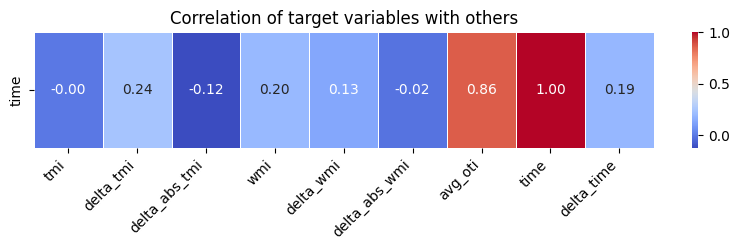

In [440]:
routes_corr_df = routes_to_corr_df.corr(method='spearman')
time_corr_row = routes_corr_df.loc[['time']]

# Plot the heatmap
plt.figure(figsize=(10, 1.5))  # Wide and short to emphasize a row
sns.heatmap(time_corr_row, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of target variables with others")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.savefig(os.path.join(VERSION_PATH, 'time_correlation_heatmap.png'))
plt.show()


C:\Users\volpato\AppData\Local\Temp\ipykernel_26212\762830976.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


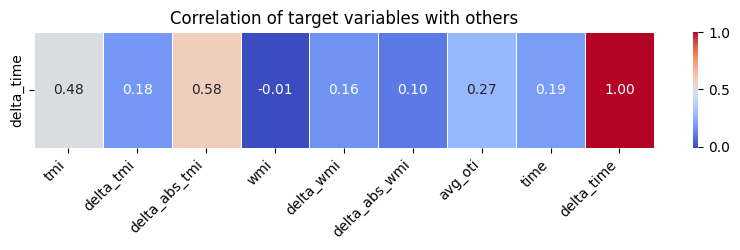

In [441]:
routes_corr_df = routes_to_corr_df.corr(method='spearman')
time_corr_row = routes_corr_df.loc[['delta_time']]

# Plot the heatmap
plt.figure(figsize=(10, 1.5))  # Wide and short to emphasize a row
sns.heatmap(time_corr_row, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of target variables with others")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.savefig(os.path.join(VERSION_PATH, 'time_correlation_heatmap.png'))
plt.show()


##### Data augmentation

In [444]:
routes_df.head()

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
0,5,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,3,"SHENZHEN, GUANGDONG, CN",4,14,22.54554,114.06830,61.761066,0.224436,0.224436,0.000000,0.0000,ROAD,3.683333,3.683333
1,3,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,33,"BRUSSELS, BRUSSELS CAPITAL, BE",6,14,50.85045,4.34878,9381.875452,0.750000,0.750000,0.000000,0.0000,AIR,18.966667,18.966667
2,33,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,43,"LEIPZIG, SAXONY, DE",8,14,51.33962,12.37129,564.352543,0.101561,0.101561,0.000000,0.0000,AIR,1.983333,1.983333
3,43,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,28,"BRESCIA, LOMBARDY, IT",10,14,45.53558,10.21472,664.754853,0.231342,0.119203,0.000000,0.0000,AIR,1.860000,1.450000
4,28,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,22,"BERGAMO, LOMBARDY, IT",12,14,45.69601,9.66721,46.277438,0.106983,0.103400,0.093648,0.1484,ROAD,0.944792,0.733333


In [445]:
import random
from typing import List, Dict, Any, Tuple
import pandas as pd
from tqdm import tqdm

def augment_routes(
    routes_df: pd.DataFrame,
    random_state: int = RANDOM_STATE,
    augment_data: bool = True,
    augmentation_prob: float = 1.0
) -> Tuple[pd.DataFrame, List[int], List[int]]:
    
    random.seed(random_state)
    augmented_routes_data: List[Dict[str, Any]] = []
    rows_skipped, rows_unusable = [], []

    if augment_data:
        for i, row in tqdm(routes_df.iloc[:-1, :].iterrows(), total=len(routes_df) - 1):
            next_row = routes_df.iloc[i + 1]

            # Skip non-continuous routes
            if row['destination'] != next_row['source']:
                rows_unusable.append(i)
                continue

            # Skip according to augmentation probability
            if random.random() > augmentation_prob:
                rows_skipped.append(i)
                continue

            augmented_distance = row['distance'] + next_row['distance']
            augmented_routes_data.append({ 
                "source": row['source'], 
                "step_source": row['step_source'],
                "latitude_source": float(row['latitude_source']), 
                "longitude_source": float(row['longitude_source']),
                "destination": next_row['destination'], 
                "step_destination": next_row['step_destination'],
                "latitude_destination": float(next_row['latitude_destination']), 
                "longitude_destination": float(next_row['longitude_destination']),
                "distance": float(augmented_distance),
                "avg_wmi": (row['avg_wmi'] * row['distance'] + next_row['avg_wmi'] * next_row['distance']) / augmented_distance,
                "wmi": (row['wmi'] * row['distance'] + next_row['wmi'] * next_row['distance']) / augmented_distance,
                "avg_tmi": (row['avg_tmi'] * row['distance'] + next_row['avg_tmi'] * next_row['distance']) / augmented_distance,
                "tmi": (row['tmi'] * row['distance'] + next_row['tmi'] * next_row['distance']) / augmented_distance,
                "transportation_mode_source": row['transportation_mode'],
                "transportation_mode_destination": next_row['transportation_mode'],
                "avg_oti": row['avg_oti'] + next_row['avg_oti'],
                "time": float(row['time'] + next_row['time'])
            })

    augmented_df = pd.DataFrame(augmented_routes_data)
    return augmented_df, rows_skipped, rows_unusable

first_level_augmented_routes_df, rows_skipped, rows_unusable = augment_routes(
    routes_df,
    random_state=RANDOM_STATE,
    augment_data=AUGMENT_DATA,
    augmentation_prob=AUGMENTATION_PROB
)

first_level_augmented_routes_df.head()

100%|██████████| 440/440 [00:00<00:00, 7853.53it/s]


,source,step_source,latitude_source,longitude_source,destination,step_destination,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode_source,transportation_mode_destination,avg_oti,time
0,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,"BRUSSELS, BRUSSELS CAPITAL, BE",6,50.85045,4.34878,9443.636517,0.746563,0.746563,0.000000,0.000000,ROAD,AIR,22.650000,22.650000
1,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,"LEIPZIG, SAXONY, DE",8,51.33962,12.37129,9946.227995,0.713207,0.713207,0.000000,0.000000,AIR,AIR,20.950000,20.950000
2,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,"BRESCIA, LOMBARDY, IT",10,45.53558,10.21472,1229.107397,0.171752,0.111102,0.000000,0.000000,AIR,AIR,3.843333,3.433333
3,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,"BERGAMO, LOMBARDY, IT",12,45.69601,9.66721,711.032292,0.223248,0.118174,0.006095,0.009659,AIR,ROAD,2.804792,2.183333
4,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,"GAZZANIGA, LOMBARDY, IT",14,45.79339,9.82976,62.925407,0.078679,0.098869,0.068872,0.172695,ROAD,ROAD,3.941667,2.933333


In [446]:
routes_df.shape[0], first_level_augmented_routes_df.shape[0], len(rows_skipped), len(rows_unusable)

(441, 324, 0, 116)

In [447]:
random.seed(RANDOM_STATE)

second_level_augmented_routes_data: List[Dict[str, Any]] = []
rows_skipped, rows_unusable = [], []

if AUGMENTATION_ITER == 2:
    for i, row in tqdm(routes_df.iloc[:-2, :].iterrows(), total=len(routes_df) - 2):
        next_row = routes_df.loc[i + 1, :]
        next_next_row = routes_df.loc[i + 2, :]
        if row['destination'] != next_row['source'] or next_row['destination'] != next_next_row['source']:
            rows_unusable.append(i)
            continue

        if random.random() > AUGMENTATION_PROB:
            rows_skipped.append(i)
            continue

        augmented_distance = row['distance'] + next_row['distance'] + next_next_row['distance']
        second_level_augmented_routes_data.append({ 
            "source": row['source'], "step_source": row['step_source'],
            "latitude_source": float(row['latitude_source']), "longitude_source": float(row['longitude_source']),
            "destination": next_next_row['destination'], "step_destination": next_next_row['step_destination'],
            "latitude_destination": next_next_row['latitude_destination'], "longitude_destination": next_next_row['longitude_destination'],
            "distance": float(augmented_distance),
            "avg_wmi": (row['avg_wmi'] * row['distance'] + next_row['avg_wmi'] * next_row['distance'] + next_next_row['avg_wmi'] * next_next_row['distance']) / augmented_distance,
            "wmi": (row['wmi'] * row['distance'] + next_row['wmi'] * next_row['distance'] + next_next_row['wmi'] * next_next_row['distance']) / augmented_distance,
            "avg_tmi": (row['avg_tmi'] * row['distance'] + next_row['avg_tmi'] * next_row['distance'] + next_next_row['avg_tmi'] * next_next_row['distance']) / augmented_distance,
            "tmi": (row['tmi'] * row['distance'] + next_row['tmi'] * next_row['distance'] + next_next_row['tmi'] * next_next_row['distance']) / augmented_distance,
            "transportation_mode_1": row['transportation_mode'],
            "trasnportation_mode_2": next_row['transportation_mode'],
            "transportation_mode_3": next_next_row['transportation_mode'],
            "avg_oti": row['avg_oti'] + next_row['avg_oti'] + next_next_row['avg_oti'],
            "time": float(row['time'] + next_row['time'] + next_next_row['time'])
        })


second_level_augmented_routes_df: pd.DataFrame = pd.DataFrame(second_level_augmented_routes_data)
second_level_augmented_routes_df.head()

""


In [448]:
routes_df.shape[0], second_level_augmented_routes_df.shape[0], len(rows_skipped), len(rows_unusable)

(441, 0, 0, 0)

In [449]:
augmented_routes_df = pd.concat([first_level_augmented_routes_df, second_level_augmented_routes_df], ignore_index=True)
augmented_routes_df.shape

(324, 17)

#### Points

In [450]:
points_df.head()

,location,latitude_source,longitude_source,latitude_destination,longitude_destination,avg_ori,time
0,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,23.01797,113.74866,0.416667,0.416667
1,"SHENZHEN, GUANGDONG, CN",22.54554,114.06830,22.54554,114.06830,10.050000,30.283333
2,"BRUSSELS, BRUSSELS CAPITAL, BE",50.85045,4.34878,50.85045,4.34878,0.016667,0.016667
3,"LEIPZIG, SAXONY, DE",51.33962,12.37129,51.33962,12.37129,14.585417,3.016667
4,"BRESCIA, LOMBARDY, IT",45.53558,10.21472,45.53558,10.21472,1.486458,1.766667


In [451]:
points_agg_df = points_df.groupby(['location'])['time'].aggregate(['count', 'mean', 'median', 'std']).reset_index().sort_values(by='count', ascending=False)
points_agg_df['cv'] = points_agg_df['std'] / points_agg_df['mean']
points_agg_df.head()

,location,count,mean,median,std,cv
8,"COLOGNE, NORTH RHINE-WESTPHALIA, DE",61,22.671858,9.316667,29.390150,1.296327
33,"TREVIOLO, LOMBARDY, IT",60,1.860556,0.383333,9.095084,4.888370
30,"SERIATE, LOMBARDY, IT",57,1.875439,1.683333,0.594586,0.317038
22,"LOUISVILLE, KENTUCKY, US",51,7.179739,4.150000,10.162568,1.415451
19,"LEIPZIG, SAXONY, DE",16,14.585417,5.450000,19.594797,1.343451


## Models

In [452]:
TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
VALIDATION_SIZE = 1 - TRAIN_SIZE - TEST_SIZE

EPSILON = 1e-6
assert abs(TRAIN_SIZE + VALIDATION_SIZE + TEST_SIZE - 1.0) < EPSILON

### Routes

#### Utility functions 

In [453]:
from sklearn.metrics import mean_absolute_error as MAE, root_mean_squared_error as RMSE, mean_absolute_percentage_error as MAPE

@dataclass(frozen=True)
class EvaluationResult:
    mae: float
    rmse: float
    mape: float
    msdp: float

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, dataset_name: str) -> EvaluationResult:
    mae: float = MAE(y_true, y_pred)
    rmse: float = RMSE(y_true, y_pred)
    mape: float = MAPE(y_true, y_pred)
    msdp: float = float(mean_signed_deviation_percentage(y_true, y_pred))
    
    print(f"\n{model_name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MSDP: {msdp:.4f}")

    with open(os.path.join(METRICS_PATH, f"{model_name}_{dataset_name}_evaluation.json"), 'w') as f:
        json.dump({
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "MSDP": msdp
        }, f, indent=4)
    
    return EvaluationResult(mae=mae, rmse=rmse, mape=mape, msdp=msdp)

In [454]:
from sklearn.model_selection import train_test_split

@dataclass(frozen=True)
class DataSplit:
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    X_test: pd.DataFrame

    y_train: pd.Series
    y_val: pd.Series
    y_test: pd.Series

def split_data(
    X: pd.DataFrame, 
    y: pd.Series,
    test_size: float = TEST_SIZE,
    validation_size: float = VALIDATION_SIZE,
    random_state: int = RANDOM_STATE
) -> DataSplit:
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    val_size_relative: float = validation_size / (1 - test_size)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_size_relative,
        random_state=random_state
    )
    
    return DataSplit(
        X_train=X_train,
        X_val=X_val,
        X_test=X_test,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test
    )

In [455]:
def concat_augmented_data(split: DataSplit,
                          X_augmented: pd.DataFrame, 
                          y_augmented: pd.Series,
                          random_state: int = RANDOM_STATE
                          ) -> DataSplit:
    

    X_train = pd.concat([split.X_train, X_augmented], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
    y_train = pd.concat([split.y_train, y_augmented], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return DataSplit(
        X_train=X_train,
        X_val=split.X_val,
        X_test=split.X_test,
        y_train=y_train,
        y_val=split.y_val,
        y_test=split.y_test
    )


In [456]:
from sklearn.preprocessing import MinMaxScaler

@dataclass(frozen=True)
class TrainableDataSplit:
    X_train: np.ndarray
    X_val: np.ndarray
    X_test: np.ndarray

    y_train: np.ndarray
    y_val: np.ndarray
    y_test: np.ndarray

def normalize_data(split: DataSplit, normalize: bool = False) -> TrainableDataSplit:
    if not normalize:
        return TrainableDataSplit(
            X_train=split.X_train.to_numpy(),
            X_val=split.X_val.to_numpy(),
            X_test=split.X_test.to_numpy(),
            y_train=split.y_train.to_numpy(),
            y_val=split.y_val.to_numpy(),
            y_test=split.y_test.to_numpy()
        )
    
    scaler: MinMaxScaler = MinMaxScaler()
    scaler.fit(split.X_train)

    X_train_norm: np.ndarray = scaler.transform(split.X_train)
    X_val_norm: np.ndarray = scaler.transform(split.X_val)
    X_test_norm: np.ndarray = scaler.transform(split.X_test)
    
    return TrainableDataSplit(
        X_train=X_train_norm,
        X_val=X_val_norm,
        X_test=X_test_norm,
        y_train=split.y_train.to_numpy(),
        y_val=split.y_val.to_numpy(),
        y_test=split.y_test.to_numpy()
    )

##### Evaluation

In [457]:
def evaluate_metrics_by_route_count(y_true: np.ndarray, y_pred:np.ndarray, routes_count: List[int]) -> pd.DataFrame:
    rmse_by_route_count = []
    mae_by_route_count = []
    mape_by_route_count = []

    for i, count in enumerate(routes_count):
        y_true_val, y_pred_val = y_true[i], y_pred[i]
        rmse_by_route_count.append(RMSE(np.array([y_true_val]), np.array([y_pred_val])))
        mae_by_route_count.append(MAE(np.array([y_true_val]), np.array([y_pred_val])))
        mape_by_route_count.append(MAPE(np.array([y_true_val]), np.array([y_pred_val])))

    metrics_by_route_count_df = pd.DataFrame(
        {
            'count': routes_count,
            'MAE': mae_by_route_count,
            'RMSE': rmse_by_route_count,
            'MAPE': mape_by_route_count
        })

    return metrics_by_route_count_df

In [458]:
def plot_predictions(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, dataset_name: str) -> None:
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='True Values', marker='o', linestyle='', color='green')
    plt.plot(y_pred, label=f'{model_name} Predictions', marker='x', linestyle='', color='blue')
    
    for i in range(len(y_true)):
        y_true_val = y_true[i]
        plt.vlines(x=i, ymin=y_true_val, ymax=y_pred[i], color='red', linestyle='--', linewidth=0.8)
    
    plt.xlabel('Sample Index')
    plt.ylabel('Time [hours]')
    plt.title(f'True vs Predicted Time  ({model_name} - {dataset_name})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(PLOT_PATH, f"{model_name}_{dataset_name}_predictions.png"))
    plt.show()

In [459]:
def plot_metrics_comparison(results_list: List[List[EvaluationResult]], models_list: List[List[str]], dataset_name: str, dataset_index: int =-1) -> None:
    # Extract metrics from results
    mae_values = [eval.mae for eval in results_list[dataset_index]]
    rmse_values = [result.rmse for result in results_list[dataset_index]]
    mape_values = [result.mape for result in results_list[dataset_index]]

    # Plot the metrics
    x = range(len(models_list[dataset_index]))  # Indices for the models

    plt.figure(figsize=(12, 6))

    # Plot MAE
    plt.plot(x, mae_values, label='MAE', marker='o', linestyle='-', color='blue')
    plt.axhline(y=mae_values[0], color='gray', linestyle='--')

    # Plot RMSE
    plt.plot(x, rmse_values, label='RMSE', marker='s', linestyle='-', color='green')
    plt.axhline(y=rmse_values[0], color='gray', linestyle='--')

    # Plot MAPE
    plt.plot(x, mape_values, label='MAPE', marker='^', linestyle='-', color='red')
    plt.axhline(y=mape_values[0], color='gray', linestyle='--')

    # Add labels and title
    plt.xticks(x, models_list[dataset_index], rotation=45)
    plt.xlabel('Models')
    plt.ylabel('Metric Values')
    plt.title(f'Comparison of Metrics Across Models ({dataset_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(os.path.join(PLOT_PATH, f"metrics_comparison_{dataset_name}.png"))
    plt.show()

##### Models

Dummy model

In [460]:
DUMMY_MODEL_NAME: str = "Dummy model"

Linear regression

In [461]:
LR_MODEL_NAME: str = "Linear Regression"

In [462]:
from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train: np.ndarray, y_train: np.ndarray,
                            X_val: np.ndarray, y_val: np.ndarray,
                            random_state: int = RANDOM_STATE) -> LinearRegression:
    lr_model: LinearRegression = LinearRegression()
    lr_model.fit(X_train, y_train)

    return lr_model

Random Forest Regressor

In [463]:
RFR_MODEL_NAME: str = "Random Forest"

In [464]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train: np.ndarray, y_train: np.ndarray,
                        X_val: np.ndarray, y_val: np.ndarray, 
                        random_state: int = RANDOM_STATE) -> RandomForestRegressor:
    
    # Initialize the Random Forest Regressor
    rf_model: RandomForestRegressor = RandomForestRegressor(
        criterion='absolute_error',  
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,                # Minimum number of samples required to split a node.
        min_samples_leaf=1,                 # Minimum number of samples required to be at a leaf node.
        max_leaf_nodes=None,                # Maximum number of leaf nodes per tree. If None, then unlimited number of leaf nodes.
        bootstrap=True,                     # Whether to bootstrap samples when building trees. If False, the whole dataset is used to build each tree.
        max_samples=0.8,                    # If bootstrapping is enabled, it controls the fraction of samples drawn for each tree.
        oob_score=True,                     # Out-of-Bag score: if true, it uses the samples left out by bootstrapping to estimate the model’s performance.
        max_features='sqrt',                # Number of features considered for each split.
        n_jobs=-1,                          # Number of jobs to run in parallel. -1 means using all processors.
        verbose=0,
        random_state=random_state
    )

    X_train_val: np.ndarray = np.concatenate((X_train, X_val), axis=0)
    y_train_val: np.ndarray = np.concatenate((y_train, y_val), axis=0)

    rf_model.fit(X_train_val, y_train_val)
    return rf_model

XGBoost

In [465]:
XGB_MODEL_NAME: str = "XGBoost"

In [466]:
from xgboost import Booster, DMatrix, train as xgb_train

XGB_DEFAULT_PARAMS: Dict[str, Any] = {
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',                # gbtree, gblinear or dart
        'max_depth': 8,                     # Maximum depth of a tree
        'min_child_weight': 3,              # Minimum sum of instance weight (hessian) needed in a child.
        'gamma': 0.1,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'eta': 0.1,                         # Learning rate
        'subsample': 0.8,                   # Subsample ratio of the training instances.
        'colsample_bytree': 0.8,            # Subsample ratio of columns when constructing each tree.
        'lambda': 0.1,                      # L2 regularization term on weights
        'alpha': 0.0,                       # L1 regularization term on weights
        'seed': RANDOM_STATE,               # Random seed for reproducibility
    }

def train_xgb(X_train: np.ndarray, y_train: np.ndarray,
              X_val: np.ndarray, y_val: np.ndarray, 
              random_state: int = RANDOM_STATE) -> Booster:
    
    # Create the DMatrix for XGBoost
    dtrain: DMatrix = DMatrix(X_train, label=y_train)
    dval: DMatrix = DMatrix(X_val, label=y_val)

    params: Dict[str, Any] = XGB_DEFAULT_PARAMS
    params['seed'] = random_state

    # Train the model
    num_rounds: int = 1000
    xgb_model: Booster = xgb_train(params, dtrain, num_rounds, evals=[(dval, 'eval')], early_stopping_rounds=100)
    return xgb_model

LightGBM

In [467]:
GBM_MODEL_NAME: str = "LightGBM"

In [468]:
import lightgbm as lgb

def train_lgb(X_train: np.ndarray, y_train: np.ndarray, 
              X_val: np.ndarray, y_val: np.ndarray,
              random_state: int = RANDOM_STATE
              ) -> lgb.Booster:
    # Create the LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',

        # Improved structure control
        'num_leaves': 31,                # Controls complexity; start with 31
        'max_depth': -1,                 # Let LGBM choose the depth (unbounded), or set e.g., 6–10 for control

        # Regularization to reduce overfitting
        'lambda_l2': 1.0,                # Stronger regularization
        'lambda_l1': 0.1,

        # Data sampling to improve generalization
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,

        # Training dynamics
        'learning_rate': 0.05,           # Slower learning, better generalization
        'min_data_in_leaf': 20,          # Avoids small leaves (can be tuned)
        'min_gain_to_split': 0.01,       # Minimum gain to make a split (a form of regularization)

        # Misc
        'seed': random_state,
        'verbose': -1
    }

    # Train the model
    num_rounds = 1000
    lgb_model = lgb.train(
        params,
        train_data,
        num_boost_round=num_rounds,
        valid_sets=[val_data],
        valid_names=['eval'],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
    )
    return lgb_model

#### Initialization

In [469]:
metrics: Tuple[str, str, str] = ('MAE', 'RMSE', 'MAPE')

datasets: List[str] = []
results: List[List[EvaluationResult]] = []
models: List[List[str]] = []

#### No geo data and only average time

In [470]:
dataset_name: str = 'No geo data and only average OTI'

datasets.append(dataset_name)
results.append([])
models.append([])

In [471]:
X: pd.DataFrame = routes_df.loc[:, ['tmi', 'wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,tmi,wmi,avg_oti
0,0.0000,0.224436,3.683333
1,0.0000,0.750000,18.966667
2,0.0000,0.101561,1.983333
3,0.0000,0.119203,1.860000
4,0.1484,0.103400,0.944792


In [472]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['tmi', 'wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)
    
X_augmented.head()

,tmi,wmi,avg_oti
0,0.000000,0.746563,22.650000
1,0.000000,0.713207,20.950000
2,0.000000,0.111102,3.843333
3,0.009659,0.118174,2.804792
4,0.172695,0.098869,3.941667


In [473]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (631, 3), X_val shape: (45, 3), X_test shape: (89, 3)
X_train_norm shape: (631, 3), X_val_norm shape: (45, 3), X_test_norm shape: (89, 3)


In [474]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (631,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [475]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


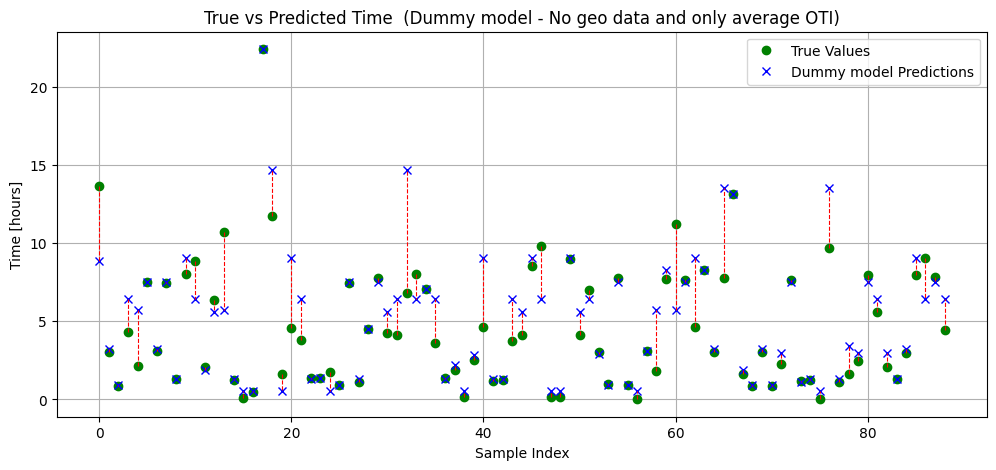

In [476]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [477]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.2019
RMSE: 1.8976
MAPE: 0.9085
MSDP: 0.6048


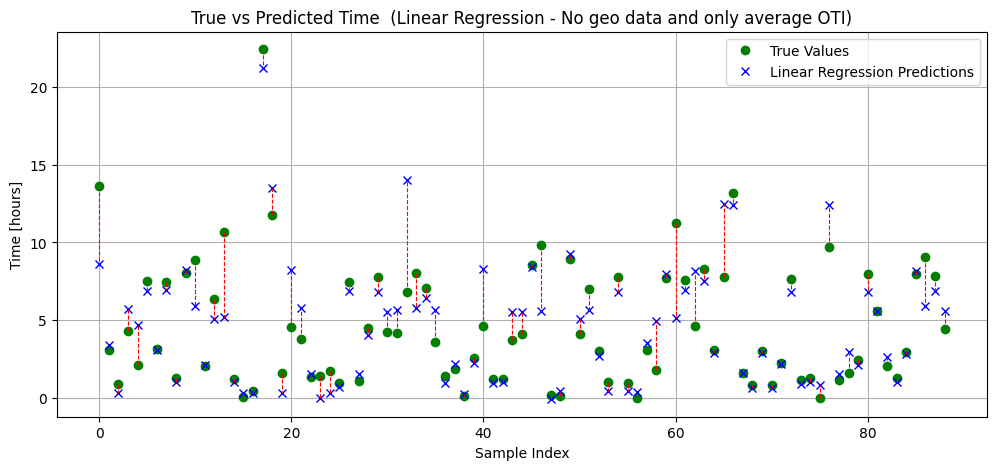

In [478]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [479]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [480]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 0.9794
RMSE: 1.6081
MAPE: 1.3592
MSDP: 1.2573


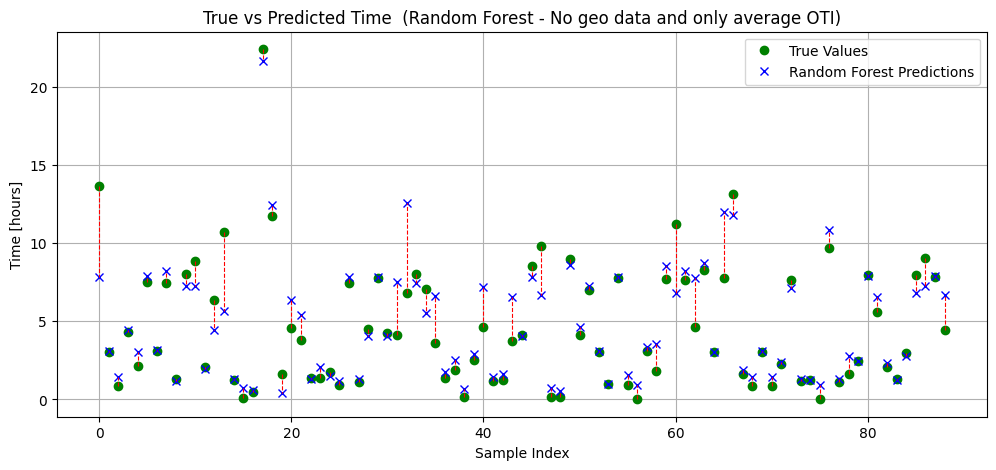

In [481]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [482]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:2.81765
[1]	eval-mae:2.72241
[2]	eval-mae:2.49704
[3]	eval-mae:2.29492
[4]	eval-mae:2.11965
[5]	eval-mae:2.05692
[6]	eval-mae:1.93809
[7]	eval-mae:1.94707
[8]	eval-mae:1.85551
[9]	eval-mae:1.74690
[10]	eval-mae:1.63562
[11]	eval-mae:1.55021
[12]	eval-mae:1.54448
[13]	eval-mae:1.45215
[14]	eval-mae:1.39281
[15]	eval-mae:1.39573
[16]	eval-mae:1.35349
[17]	eval-mae:1.34442
[18]	eval-mae:1.32305
[19]	eval-mae:1.29076
[20]	eval-mae:1.24630
[21]	eval-mae:1.21602
[22]	eval-mae:1.20594
[23]	eval-mae:1.17811
[24]	eval-mae:1.16089
[25]	eval-mae:1.13585
[26]	eval-mae:1.12474
[27]	eval-mae:1.12778
[28]	eval-mae:1.11186
[29]	eval-mae:1.11598
[30]	eval-mae:1.11121
[31]	eval-mae:1.11264
[32]	eval-mae:1.11160
[33]	eval-mae:1.10560
[34]	eval-mae:1.10424
[35]	eval-mae:1.10399
[36]	eval-mae:1.09773
[37]	eval-mae:1.09350
[38]	eval-mae:1.09135
[39]	eval-mae:1.08070
[40]	eval-mae:1.07221
[41]	eval-mae:1.06759
[42]	eval-mae:1.07044
[43]	eval-mae:1.06768
[44]	eval-mae:1.06527
[45]	eval-mae:1.0638

In [483]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 1.0913
RMSE: 2.1495
MAPE: 0.9036
MSDP: 0.6706


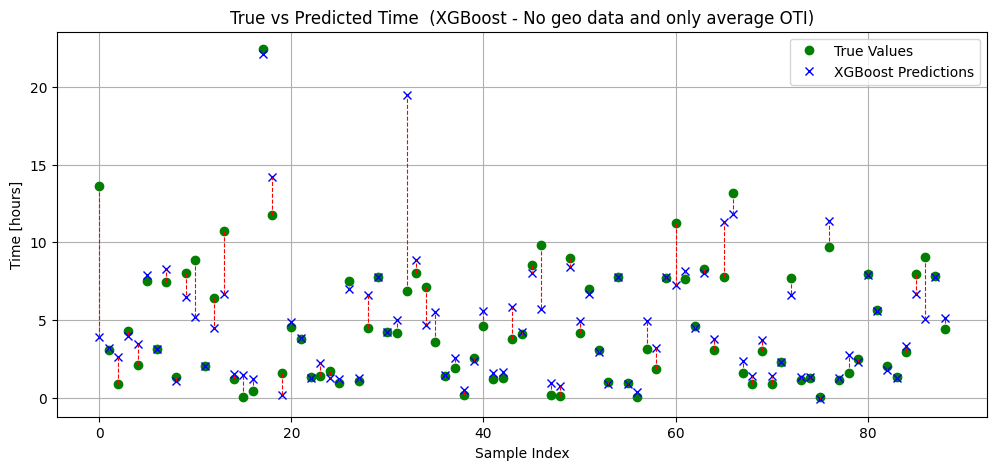

In [484]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [485]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	eval's l1: 1.21292


In [486]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)       # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.0524
RMSE: 1.6600
MAPE: 0.9205
MSDP: 0.5403


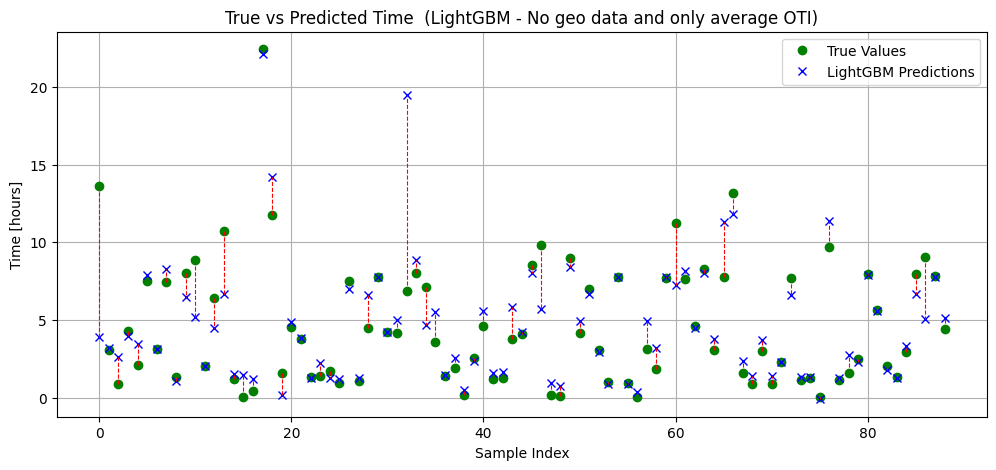

In [487]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

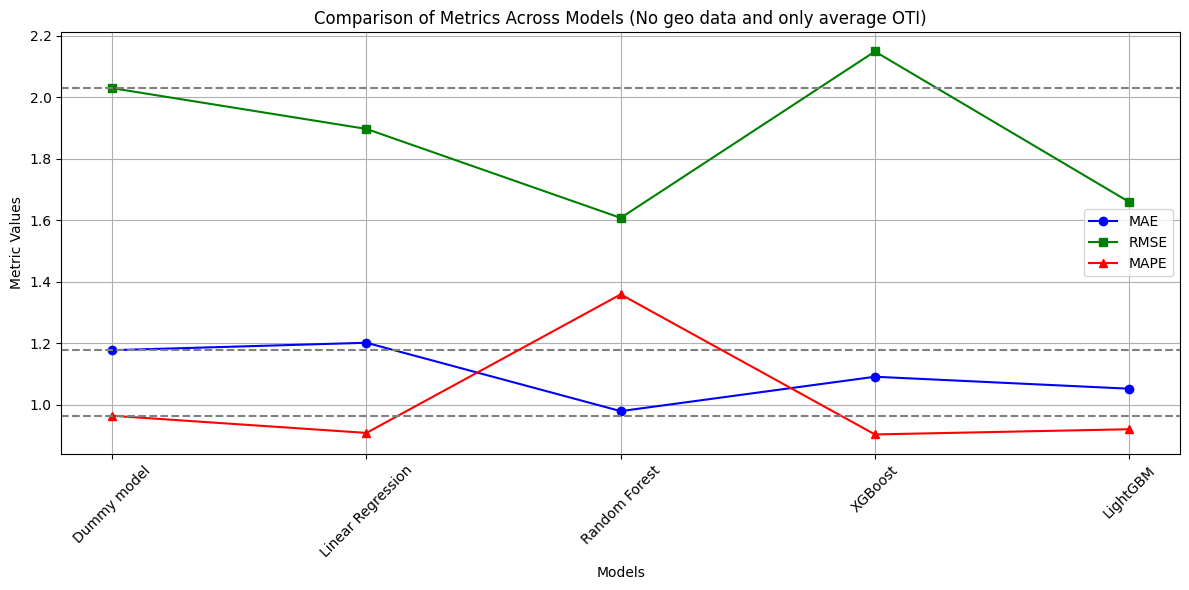

In [488]:
plot_metrics_comparison(results, models, dataset_name)

#### Geo data and only average time

In [489]:
dataset_name: str = 'Geo data and only average OTI'
datasets.append(dataset_name)
results.append([])
models.append([])

In [490]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'tmi', 'wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,tmi,wmi,avg_oti
0,61.761066,0.0000,0.224436,3.683333
1,9381.875452,0.0000,0.750000,18.966667
2,564.352543,0.0000,0.101561,1.983333
3,664.754853,0.0000,0.119203,1.860000
4,46.277438,0.1484,0.103400,0.944792


In [491]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'tmi', 'wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,tmi,wmi,avg_oti
0,9443.636517,0.000000,0.746563,22.650000
1,9946.227995,0.000000,0.713207,20.950000
2,1229.107397,0.000000,0.111102,3.843333
3,711.032292,0.009659,0.118174,2.804792
4,62.925407,0.172695,0.098869,3.941667


In [492]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (631, 4), X_val shape: (45, 4), X_test shape: (89, 4)
X_train_norm shape: (631, 4), X_val_norm shape: (45, 4), X_test_norm shape: (89, 4)


In [493]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (631,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [494]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


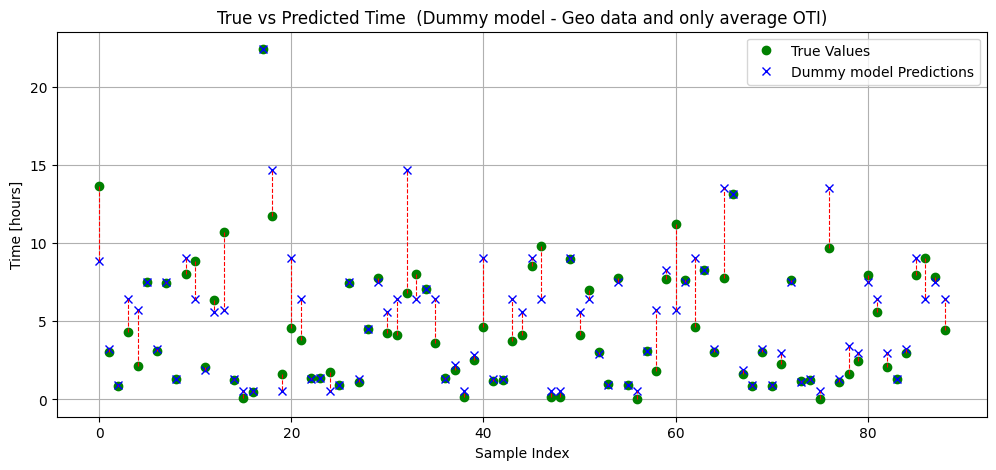

In [495]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [496]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.1699
RMSE: 1.8962
MAPE: 0.8314
MSDP: 0.5462


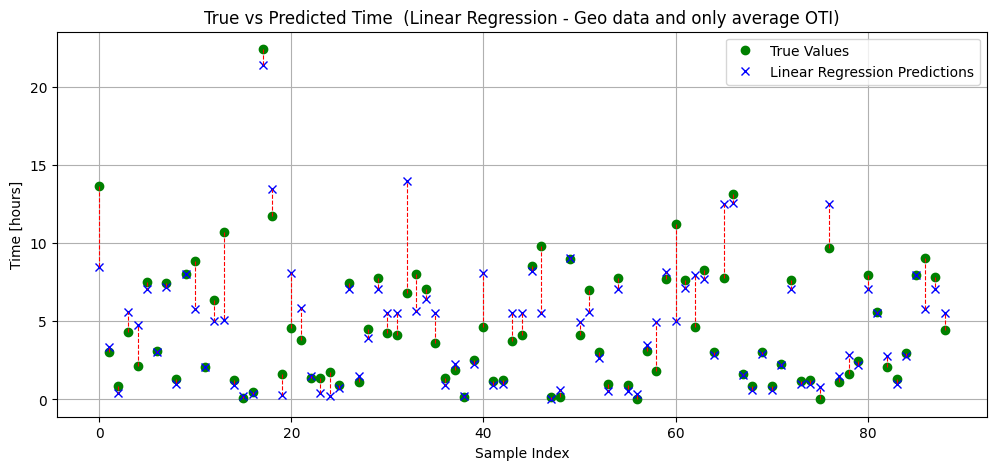

In [497]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [498]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [499]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 1.0004
RMSE: 1.8031
MAPE: 0.8326
MSDP: 0.7243


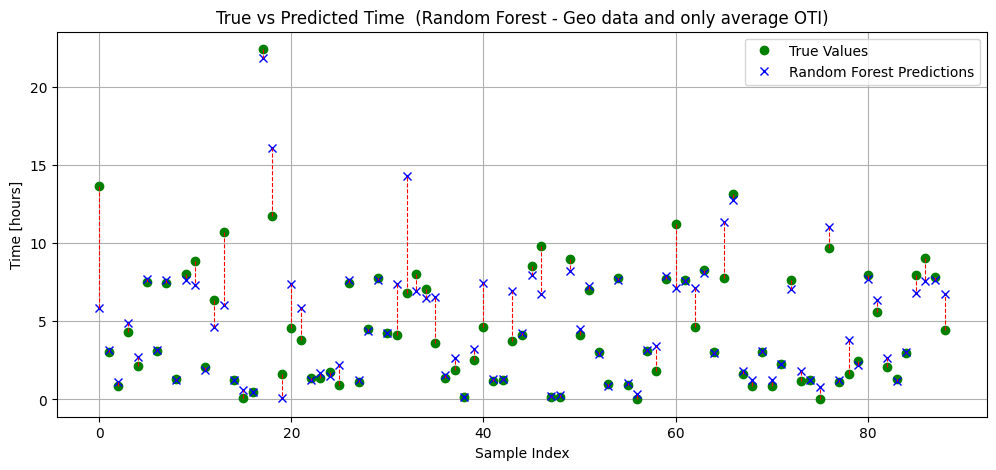

In [500]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [501]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:2.78839
[1]	eval-mae:2.58736
[2]	eval-mae:2.40873
[3]	eval-mae:2.23187
[4]	eval-mae:2.07402
[5]	eval-mae:1.90651
[6]	eval-mae:1.78179
[7]	eval-mae:1.64426
[8]	eval-mae:1.52497
[9]	eval-mae:1.43639
[10]	eval-mae:1.35294
[11]	eval-mae:1.27666
[12]	eval-mae:1.22570
[13]	eval-mae:1.17528
[14]	eval-mae:1.14039
[15]	eval-mae:1.12167
[16]	eval-mae:1.10378
[17]	eval-mae:1.08173
[18]	eval-mae:1.07088
[19]	eval-mae:1.05653
[20]	eval-mae:1.05612
[21]	eval-mae:1.06372
[22]	eval-mae:1.07883
[23]	eval-mae:1.06695
[24]	eval-mae:1.06500
[25]	eval-mae:1.05665
[26]	eval-mae:1.05499
[27]	eval-mae:1.04398
[28]	eval-mae:1.04826
[29]	eval-mae:1.04550
[30]	eval-mae:1.04810
[31]	eval-mae:1.04333
[32]	eval-mae:1.03376
[33]	eval-mae:1.03837
[34]	eval-mae:1.04187
[35]	eval-mae:1.04002
[36]	eval-mae:1.04499
[37]	eval-mae:1.05024
[38]	eval-mae:1.05147
[39]	eval-mae:1.05514
[40]	eval-mae:1.05515
[41]	eval-mae:1.05431
[42]	eval-mae:1.05240
[43]	eval-mae:1.05198
[44]	eval-mae:1.05252
[45]	eval-mae:1.0625

In [502]:
dtest: DMatrix = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb: np.ndarray = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 0.8576
RMSE: 1.5921
MAPE: 0.6974
MSDP: 0.5660


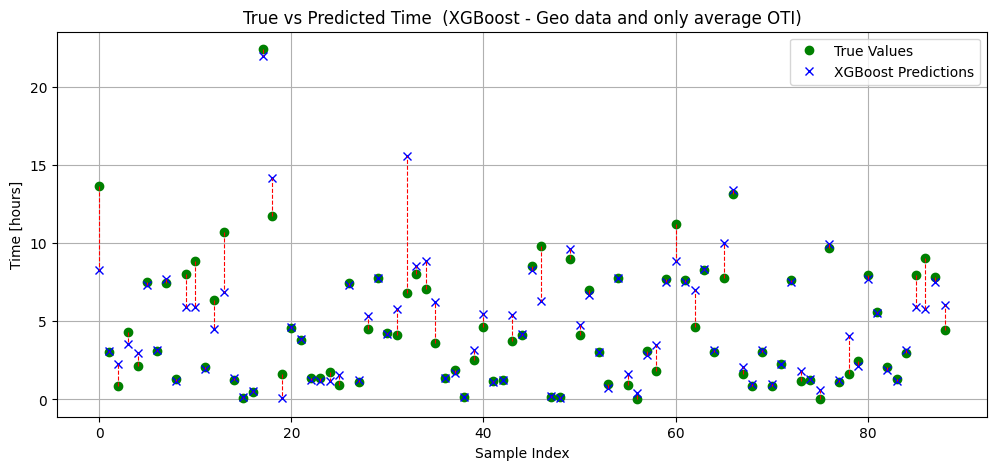

In [503]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [504]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	eval's l1: 1.10924


In [505]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)     # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.0700
RMSE: 1.7359
MAPE: 1.3360
MSDP: 1.0970


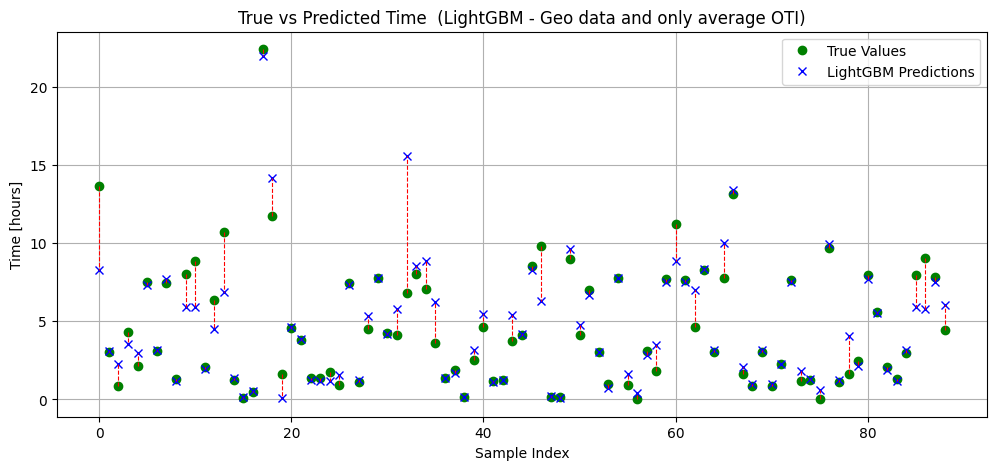

In [506]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

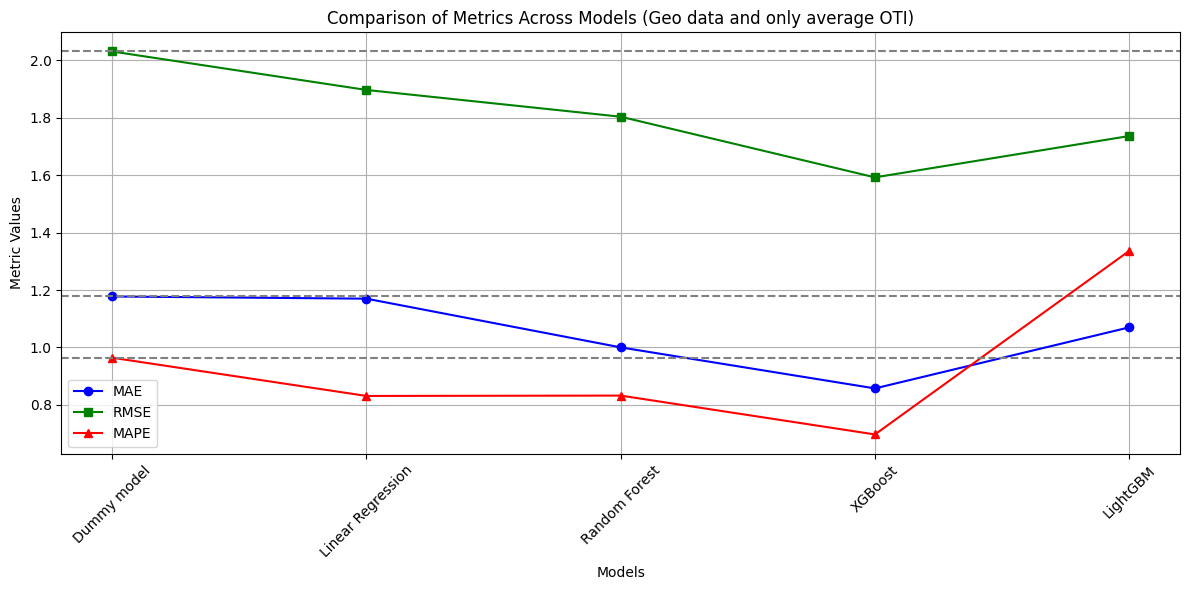

In [507]:
plot_metrics_comparison(results, models, dataset_name)

#### No geo data and all averages

In [508]:
dataset_name: str = 'No geo data all averages'
datasets.append(dataset_name)
models.append([])
results.append([])

In [509]:
X: pd.DataFrame = routes_df.loc[:, ['tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,0.0000,0.000000,0.224436,0.224436,3.683333
1,0.0000,0.000000,0.750000,0.750000,18.966667
2,0.0000,0.000000,0.101561,0.101561,1.983333
3,0.0000,0.000000,0.119203,0.231342,1.860000
4,0.1484,0.093648,0.103400,0.106983,0.944792


In [510]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,0.000000,0.000000,0.746563,0.746563,22.650000
1,0.000000,0.000000,0.713207,0.713207,20.950000
2,0.000000,0.000000,0.111102,0.171752,3.843333
3,0.009659,0.006095,0.118174,0.223248,2.804792
4,0.172695,0.068872,0.098869,0.078679,3.941667


In [511]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (631, 4), X_val shape: (45, 4), X_test shape: (89, 4)
X_train_norm shape: (631, 5), X_val_norm shape: (45, 5), X_test_norm shape: (89, 5)


In [512]:
y_train, y_val, y_test = trainable_normalized_splits.y_train, trainable_normalized_splits.y_val, trainable_normalized_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (631,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [513]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


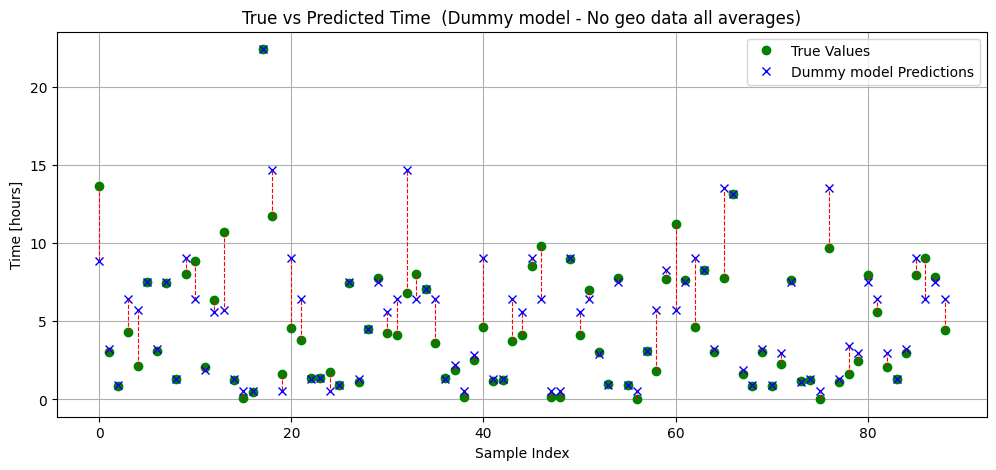

In [514]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [515]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.3742
RMSE: 1.9699
MAPE: 1.5718
MSDP: 1.0205


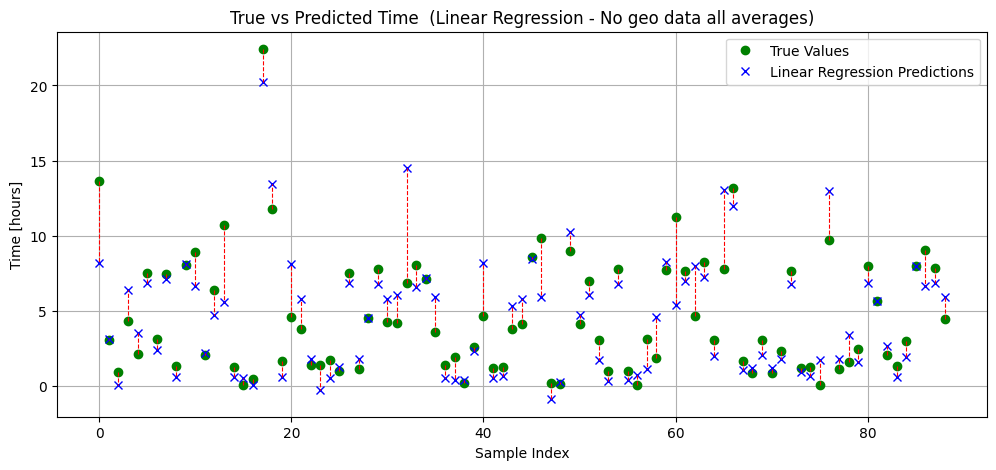

In [516]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [517]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [518]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 1.0004
RMSE: 1.8031
MAPE: 0.8326
MSDP: 0.7243


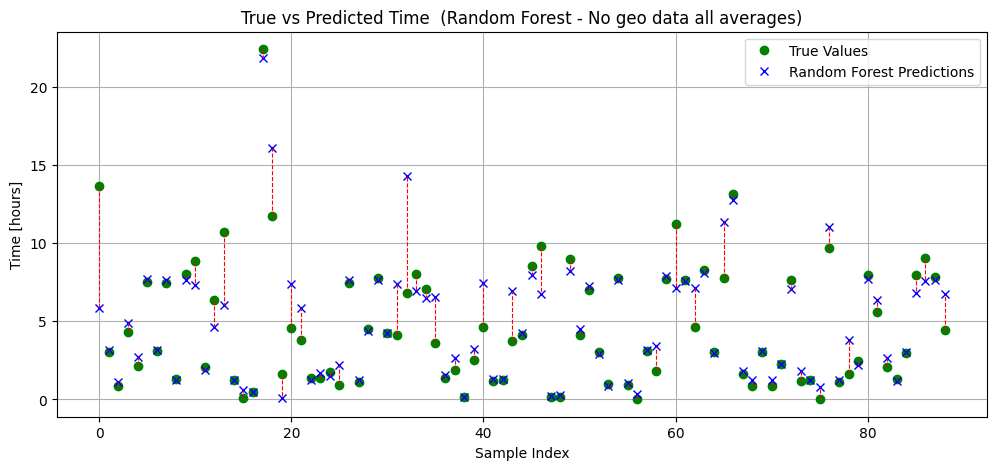

In [519]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [520]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:2.78839
[1]	eval-mae:2.58736
[2]	eval-mae:2.40873
[3]	eval-mae:2.23187
[4]	eval-mae:2.07402
[5]	eval-mae:1.90651
[6]	eval-mae:1.78179
[7]	eval-mae:1.64426
[8]	eval-mae:1.52497
[9]	eval-mae:1.43639
[10]	eval-mae:1.35294
[11]	eval-mae:1.27666
[12]	eval-mae:1.22570
[13]	eval-mae:1.17528
[14]	eval-mae:1.14039
[15]	eval-mae:1.12167
[16]	eval-mae:1.10378
[17]	eval-mae:1.08173
[18]	eval-mae:1.07088
[19]	eval-mae:1.05653
[20]	eval-mae:1.05612
[21]	eval-mae:1.06372
[22]	eval-mae:1.07883
[23]	eval-mae:1.06695
[24]	eval-mae:1.06500
[25]	eval-mae:1.05665
[26]	eval-mae:1.05499
[27]	eval-mae:1.04398
[28]	eval-mae:1.04826
[29]	eval-mae:1.04550
[30]	eval-mae:1.04810
[31]	eval-mae:1.04333
[32]	eval-mae:1.03376
[33]	eval-mae:1.03837
[34]	eval-mae:1.04187
[35]	eval-mae:1.04002
[36]	eval-mae:1.04499
[37]	eval-mae:1.05024
[38]	eval-mae:1.05147
[39]	eval-mae:1.05514
[40]	eval-mae:1.05515
[41]	eval-mae:1.05431
[42]	eval-mae:1.05240
[43]	eval-mae:1.05198
[44]	eval-mae:1.05252
[45]	eval-mae:1.0625

In [521]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 0.8576
RMSE: 1.5921
MAPE: 0.6974
MSDP: 0.5660


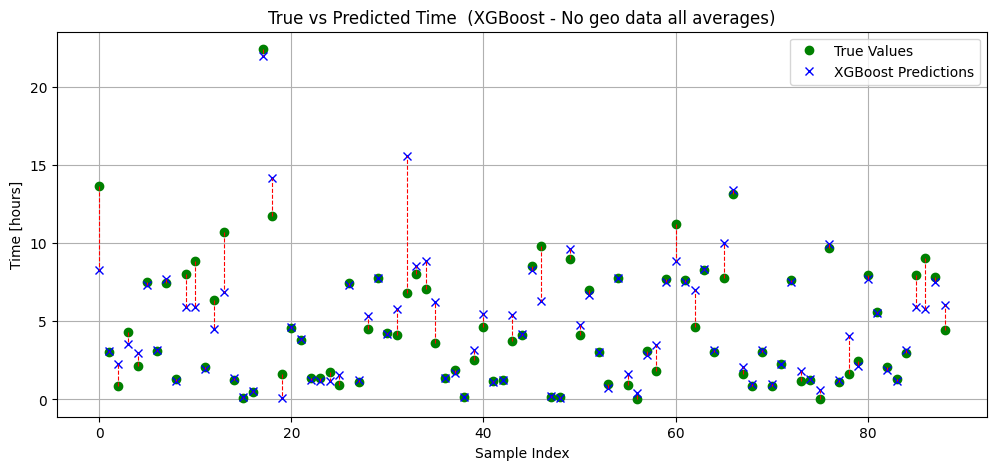

In [522]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [523]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	eval's l1: 1.11644


In [524]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)       # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.0411
RMSE: 1.7089
MAPE: 1.4047
MSDP: 1.1691


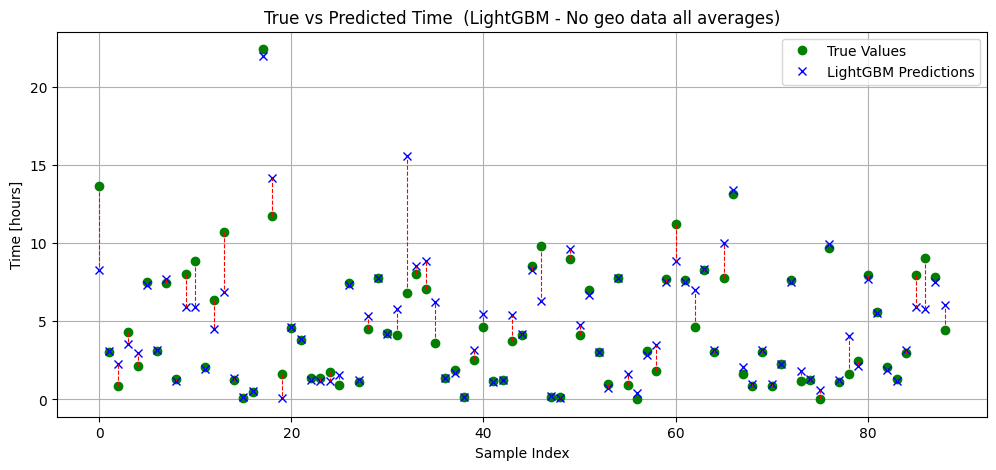

In [525]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

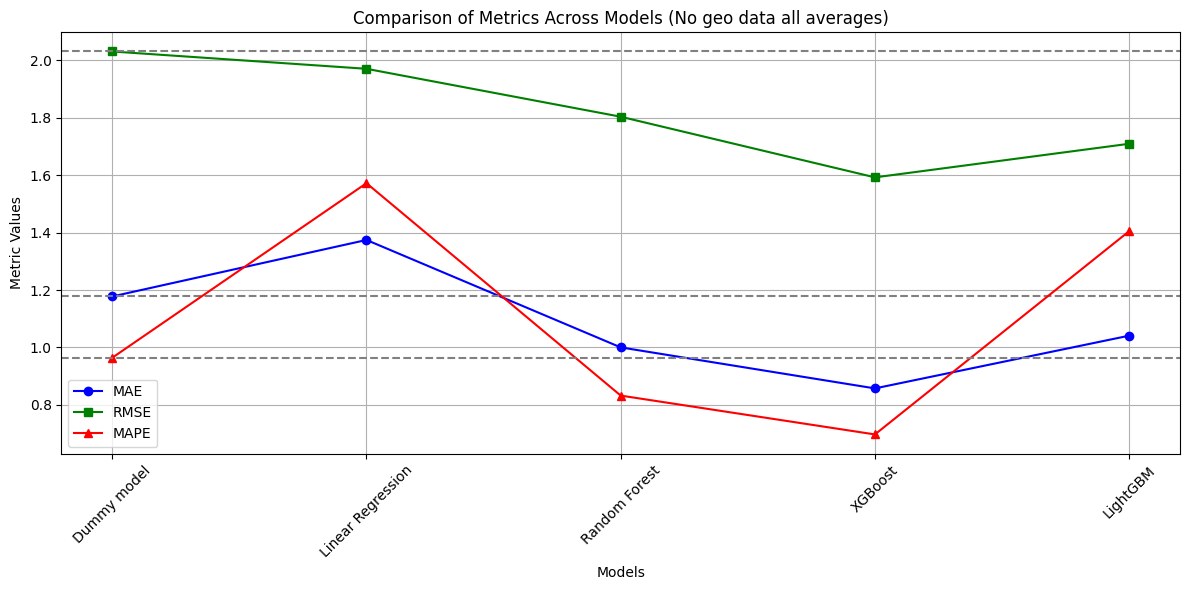

In [526]:
plot_metrics_comparison(results, models, dataset_name)

#### Geo data and all averages

In [527]:
dataset_name: str = 'Geo data and all averages'
datasets.append(dataset_name)
models.append([])
results.append([])

In [528]:
X = routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
y = X.pop('time')

X.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,61.761066,0.0000,0.000000,0.224436,0.224436,3.683333
1,9381.875452,0.0000,0.000000,0.750000,0.750000,18.966667
2,564.352543,0.0000,0.000000,0.101561,0.101561,1.983333
3,664.754853,0.0000,0.000000,0.119203,0.231342,1.860000
4,46.277438,0.1484,0.093648,0.103400,0.106983,0.944792


In [529]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,9443.636517,0.000000,0.000000,0.746563,0.746563,22.650000
1,9946.227995,0.000000,0.000000,0.713207,0.713207,20.950000
2,1229.107397,0.000000,0.000000,0.111102,0.171752,3.843333
3,711.032292,0.009659,0.006095,0.118174,0.223248,2.804792
4,62.925407,0.172695,0.068872,0.098869,0.078679,3.941667


In [530]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (631, 6), X_val shape: (45, 6), X_test shape: (89, 6)
X_train_norm shape: (631, 6), X_val_norm shape: (45, 6), X_test_norm shape: (89, 6)


In [531]:
y_train, y_val, y_test = trainable_normalized_splits.y_train, trainable_normalized_splits.y_val, trainable_normalized_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (631,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [532]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


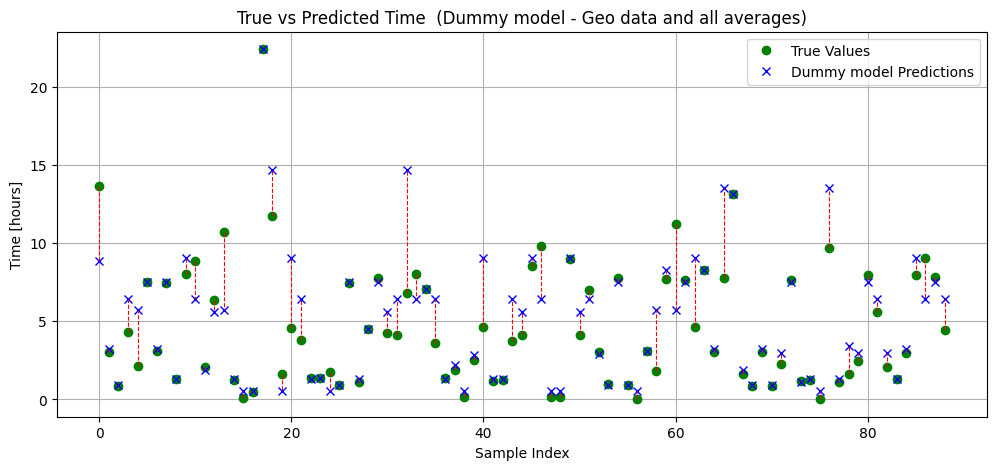

In [533]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [534]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.3438
RMSE: 1.9592
MAPE: 1.5033
MSDP: 0.9768


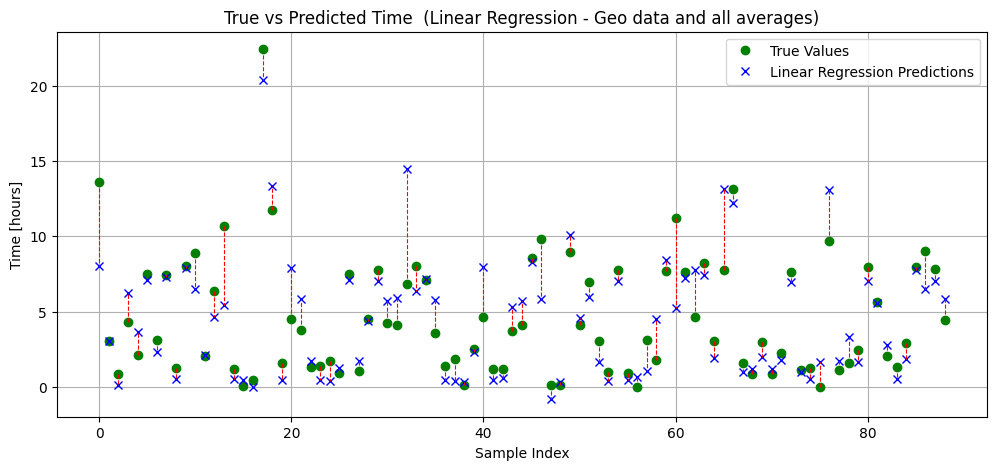

In [535]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [536]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [537]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 1.0465
RMSE: 1.9367
MAPE: 0.7227
MSDP: 0.6056


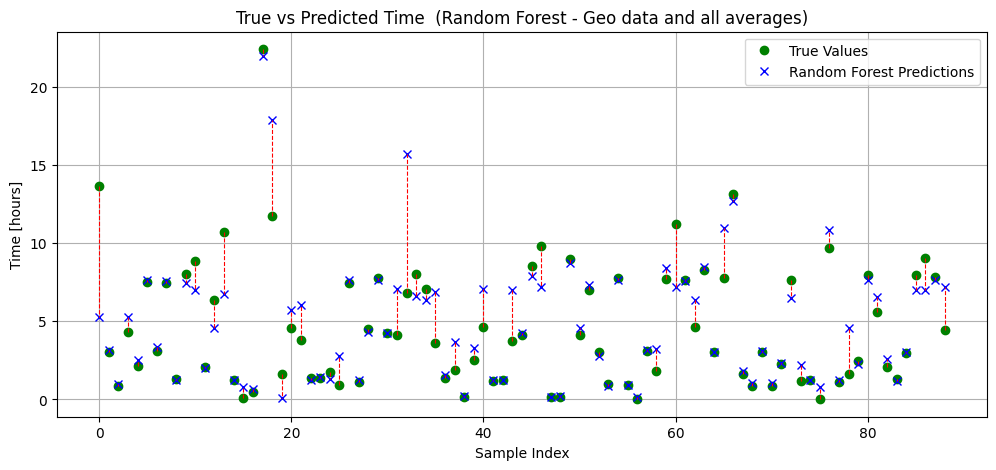

In [538]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [539]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:2.77291
[1]	eval-mae:2.53936
[2]	eval-mae:2.30999
[3]	eval-mae:2.10994
[4]	eval-mae:1.88690
[5]	eval-mae:1.74565
[6]	eval-mae:1.58743
[7]	eval-mae:1.47136
[8]	eval-mae:1.38464
[9]	eval-mae:1.32015
[10]	eval-mae:1.26877
[11]	eval-mae:1.22700
[12]	eval-mae:1.19601
[13]	eval-mae:1.16520
[14]	eval-mae:1.13597
[15]	eval-mae:1.12463
[16]	eval-mae:1.12483
[17]	eval-mae:1.10257
[18]	eval-mae:1.07448
[19]	eval-mae:1.08606
[20]	eval-mae:1.07359
[21]	eval-mae:1.06991
[22]	eval-mae:1.06302
[23]	eval-mae:1.05769
[24]	eval-mae:1.04294
[25]	eval-mae:1.03645
[26]	eval-mae:1.04019
[27]	eval-mae:1.03825
[28]	eval-mae:1.02907
[29]	eval-mae:1.02902
[30]	eval-mae:1.02708
[31]	eval-mae:1.01925
[32]	eval-mae:1.01571
[33]	eval-mae:1.01805
[34]	eval-mae:1.01659
[35]	eval-mae:1.02998
[36]	eval-mae:1.02810
[37]	eval-mae:1.02818
[38]	eval-mae:1.03302
[39]	eval-mae:1.03208
[40]	eval-mae:1.03177
[41]	eval-mae:1.03248
[42]	eval-mae:1.02265
[43]	eval-mae:1.02320
[44]	eval-mae:1.02500
[45]	eval-mae:1.0268

In [540]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 0.9002
RMSE: 1.6189
MAPE: 0.4673
MSDP: 0.3141


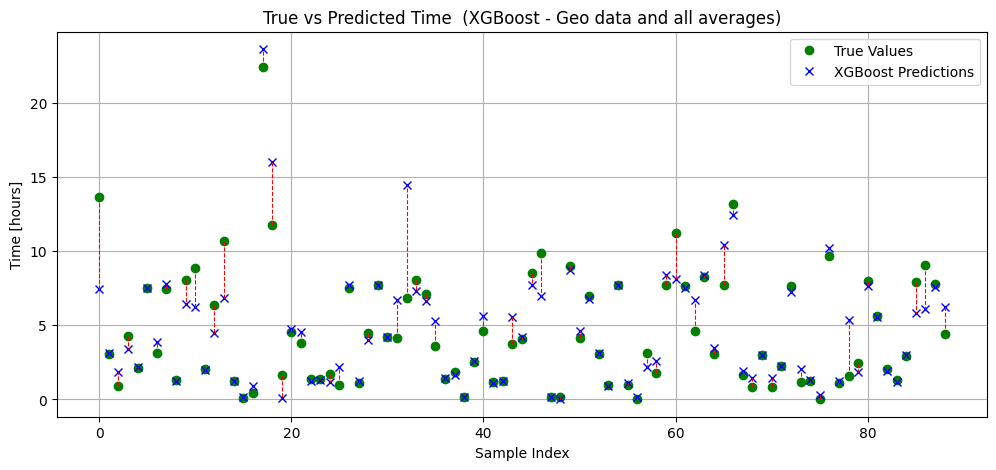

In [541]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [542]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	eval's l1: 1.05089


In [543]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)       # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.0200
RMSE: 1.7811
MAPE: 0.8815
MSDP: 0.2023


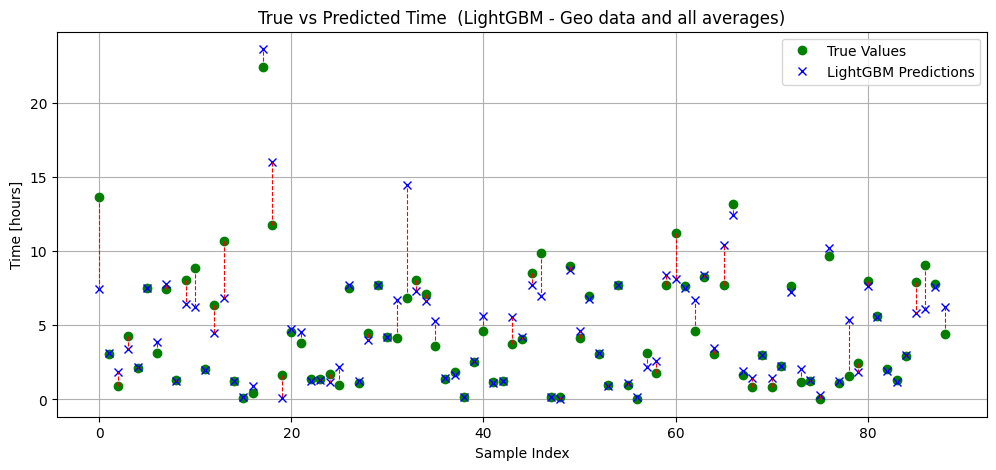

In [544]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

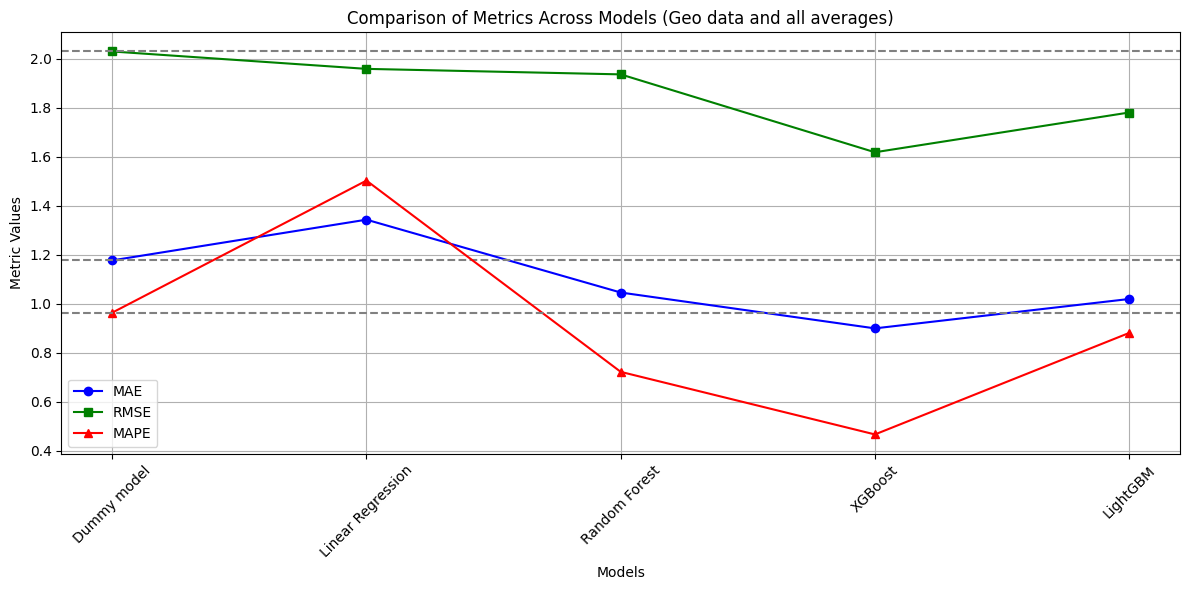

In [545]:
plot_metrics_comparison(results, models, dataset_name)

#### Comparison

In [546]:
def plot_model_metrics_across_datasets(results: List[List['EvaluationResult']], 
                                       datasets: List[str], 
                                       model: str,metrics: Tuple[str, str, str],
                                       index: int
                                       ) -> None:

    # Extract metrics
    eval_metrics: List[EvaluationResult] = [evals[index] for evals in results]
    mae: List[float] = [eval.mae for eval in eval_metrics]
    rmse: List[float] = [eval.rmse for eval in eval_metrics]
    mape: List[float] = [eval.mape for eval in eval_metrics]

    x_labels: Tuple[str, str, str] = metrics
    x = np.arange(len(x_labels))
    bar_width: float = 0.2

    plt.figure(figsize=(10, 5))

    for i, dataset_name in enumerate(datasets):
        values = [mae[i], rmse[i], mape[i]]
        bars = plt.bar(x + i * bar_width, values, width=bar_width, label=dataset_name, edgecolor='black')
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.xlabel('Metrics')
    plt.ylabel('Metric Values')
    plt.title(f"{model} Metrics Comparison Across Datasets")
    plt.xticks(x + bar_width * (len(datasets) - 1) / 2, x_labels)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_PATH, f"{model}_metrics_across_datasets.png"))
    plt.show()

##### Linear regression

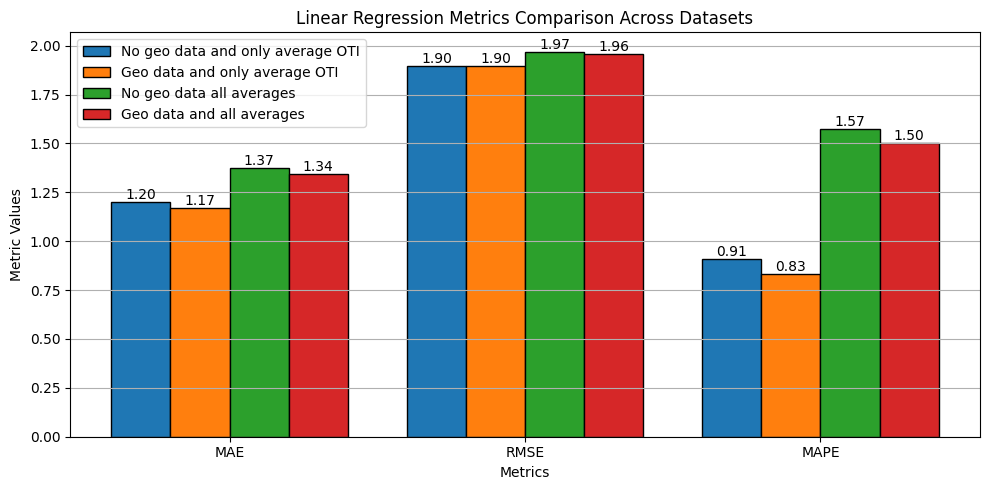

In [547]:
plot_model_metrics_across_datasets(results, datasets, LR_MODEL_NAME, metrics, 1)

##### Random Forest

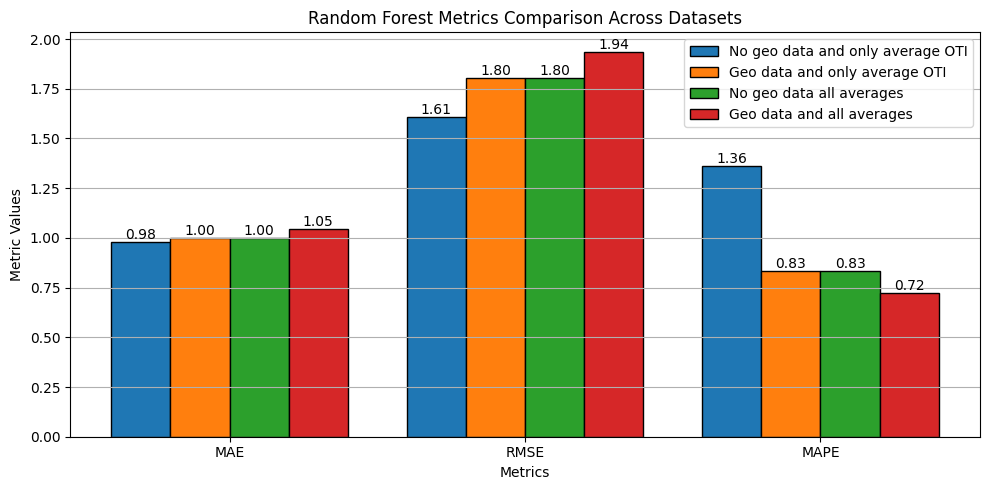

In [548]:
plot_model_metrics_across_datasets(results, datasets, RFR_MODEL_NAME, metrics, 2)

##### XGBoost

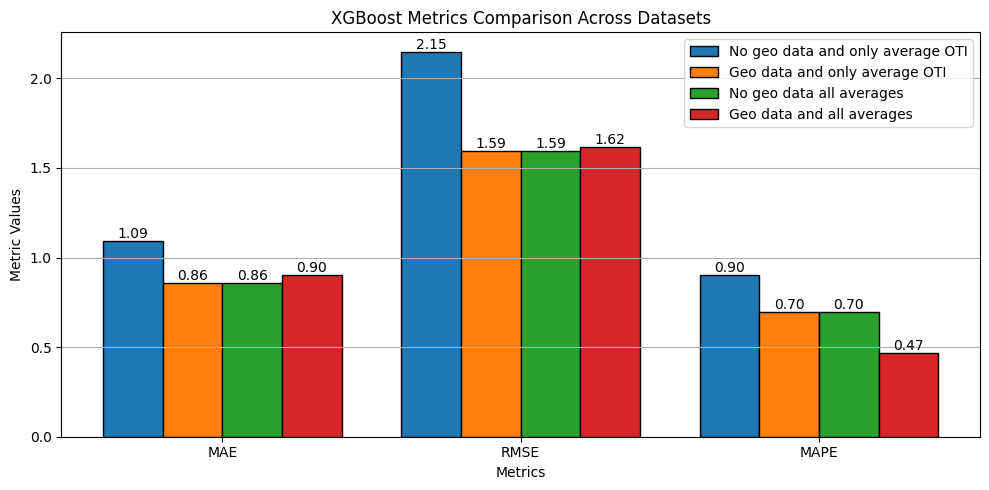

In [549]:
plot_model_metrics_across_datasets(results, datasets, XGB_MODEL_NAME, metrics, 3)

##### LightGBM

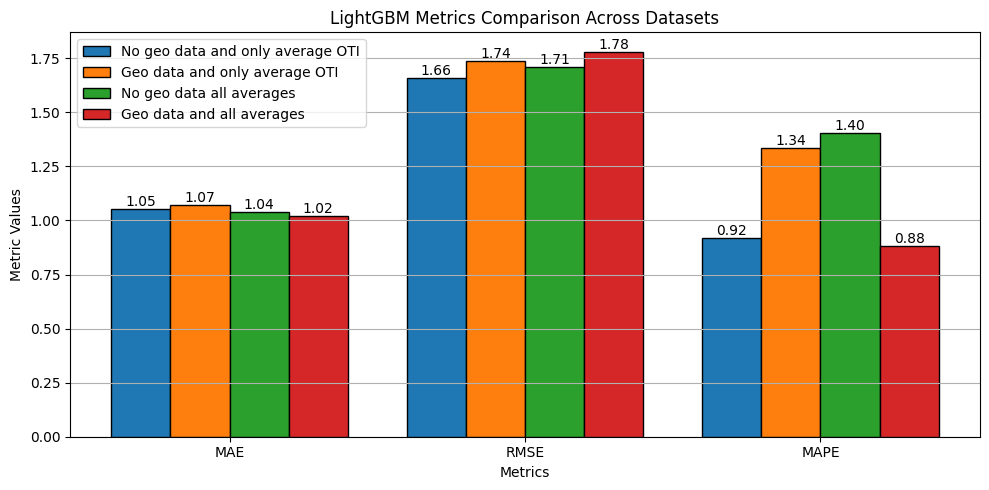

In [550]:
plot_model_metrics_across_datasets(results, datasets, GBM_MODEL_NAME, metrics, 4)

#### Models evaluation

In [551]:
metrics

('MAE', 'RMSE', 'MAPE')

##### MAE

In [552]:
METRIC_NAME: str = 'MAE'

In [553]:
results_flatten = np.array([[eval.mae for eval in m] for m in results]).flatten()
ranking = np.argsort(results_flatten)

ranked_datasets_indexes = ranking // len(models[0])
ranked_models_indexes = ranking % len(models[0])

ranked_models = [f'{models[dataset_index][model_index]} - {datasets[dataset_index]}' for dataset_index, model_index in zip(ranked_datasets_indexes, ranked_models_indexes)]

print(f'Ranking of models based on {METRIC_NAME}:')
for i, model in enumerate(ranked_models):
    print(f'\t{model}: {results_flatten[ranking][i]}')

Ranking of models based on MAE:
	XGBoost - No geo data all averages: 0.8576204272524249
	XGBoost - Geo data and only average OTI: 0.8576204272524249
	XGBoost - Geo data and all averages: 0.9001535754608974
	Random Forest - No geo data and only average OTI: 0.9794007490636701
	Random Forest - No geo data all averages: 1.0003707865168534
	Random Forest - Geo data and only average OTI: 1.0003707865168534
	LightGBM - Geo data and all averages: 1.020036561830997
	LightGBM - No geo data all averages: 1.041148785161558
	Random Forest - Geo data and all averages: 1.046462546816479
	LightGBM - No geo data and only average OTI: 1.0523806660017876
	LightGBM - Geo data and only average OTI: 1.07000202198945
	XGBoost - No geo data and only average OTI: 1.091300709166107
	Linear Regression - Geo data and only average OTI: 1.1698952472737292
	Dummy model - Geo data and all averages: 1.1776020893120611
	Dummy model - No geo data and only average OTI: 1.1776020893120611
	Dummy model - Geo data and only

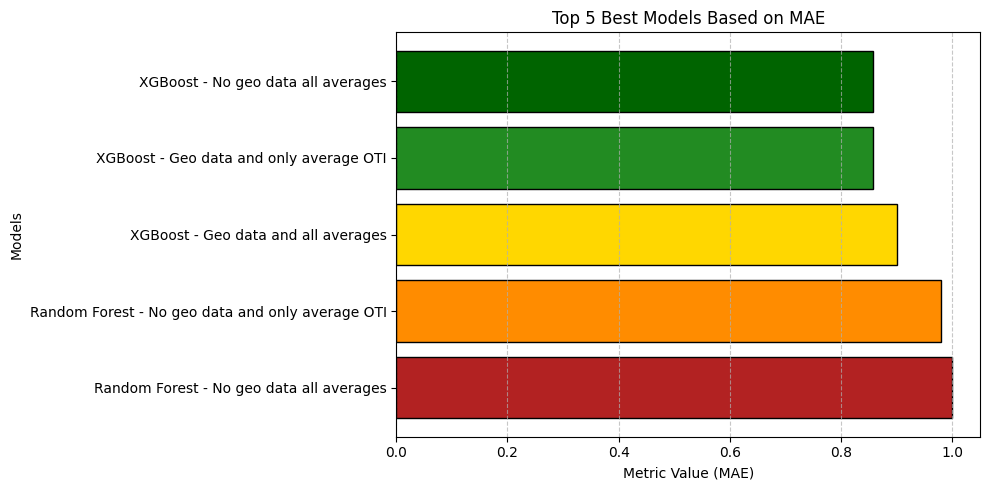

In [554]:
K: int = 5

best_results = results_flatten[ranking][:K]
best_models = ranked_models[:K]

colors = ['#006400', '#228B22', '#FFD700', '#FF8C00', '#B22222']

plt.figure(figsize=(10, 5))

plt.barh(best_models, best_results, color=colors, edgecolor='black', linewidth=1)
plt.xlabel(f'Metric Value ({METRIC_NAME})')
plt.ylabel('Models')
plt.title(f'Top {K} Best Models Based on {METRIC_NAME}')
plt.gca().invert_yaxis()                                            # Invert y-axis to show the best model at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, f'top_{K}_models_based_on_{METRIC_NAME}.png'))
plt.show()

##### RMSE

In [555]:
METRIC_NAME: str = 'RMSE'

In [556]:
results_flatten = np.array([[eval.rmse for eval in m] for m in results]).flatten()
ranking = np.argsort(results_flatten)

ranked_datasets_indexes = ranking // len(models[0])
ranked_models_indexes = ranking % len(models[0])

ranked_models = [f'{models[dataset_index][model_index]} - {datasets[dataset_index]}' for dataset_index, model_index in zip(ranked_datasets_indexes, ranked_models_indexes)]

print(f'Ranking of models based on {METRIC_NAME}:')
for i, model in enumerate(ranked_models):
    print(f'\t{model}: {results_flatten[ranking][i]}')

Ranking of models based on RMSE:
	XGBoost - No geo data all averages: 1.5920695435831436
	XGBoost - Geo data and only average OTI: 1.5920695435831436
	Random Forest - No geo data and only average OTI: 1.6080834433570292
	XGBoost - Geo data and all averages: 1.6188661741583825
	LightGBM - No geo data and only average OTI: 1.6599970055654303
	LightGBM - No geo data all averages: 1.7089475916439931
	LightGBM - Geo data and only average OTI: 1.7359389041970597
	LightGBM - Geo data and all averages: 1.7811323370028997
	Random Forest - Geo data and only average OTI: 1.803122210411817
	Random Forest - No geo data all averages: 1.8031222104118172
	Linear Regression - Geo data and only average OTI: 1.8962431359445138
	Linear Regression - No geo data and only average OTI: 1.897559739509824
	Random Forest - Geo data and all averages: 1.9367364569751166
	Linear Regression - Geo data and all averages: 1.9592072206560054
	Linear Regression - No geo data all averages: 1.9699084853810935
	Dummy model 

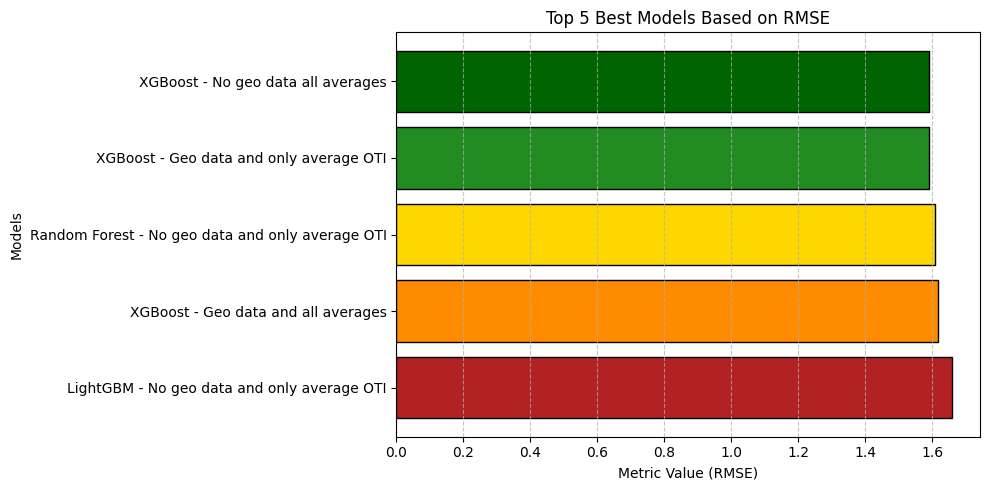

In [557]:
K: int = 5

best_results = results_flatten[ranking][:K]
best_models = ranked_models[:K]

colors = ['#006400', '#228B22', '#FFD700', '#FF8C00', '#B22222']

plt.figure(figsize=(10, 5))

plt.barh(best_models, best_results, color=colors, edgecolor='black', linewidth=1)
plt.xlabel(f'Metric Value ({METRIC_NAME})')
plt.ylabel('Models')
plt.title(f'Top {K} Best Models Based on {METRIC_NAME}')
plt.gca().invert_yaxis()                                            # Invert y-axis to show the best model at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, f'top_{K}_models_based_on_{METRIC_NAME}.png'))
plt.show()

##### MAPE

In [558]:
METRIC_NAME: str = 'MAPE'

In [559]:
results_flatten = np.array([[eval.mape for eval in m] for m in results]).flatten()
ranking = np.argsort(results_flatten)

ranked_datasets_indexes = ranking // len(models[0])
ranked_models_indexes = ranking % len(models[0])

ranked_models = [f'{models[dataset_index][model_index]} - {datasets[dataset_index]}' for dataset_index, model_index in zip(ranked_datasets_indexes, ranked_models_indexes)]

print(f'Ranking of models based on {METRIC_NAME}:')
for i, model in enumerate(ranked_models):
    print(f'\t{model}: {results_flatten[ranking][i]}')

Ranking of models based on MAPE:
	XGBoost - Geo data and all averages: 0.4673074209581897
	XGBoost - No geo data all averages: 0.6974355369797092
	XGBoost - Geo data and only average OTI: 0.6974355369797092
	Random Forest - Geo data and all averages: 0.7227335888572274
	Linear Regression - Geo data and only average OTI: 0.8313545680280269
	Random Forest - Geo data and only average OTI: 0.8326410205863162
	Random Forest - No geo data all averages: 0.8326410205863162
	LightGBM - Geo data and all averages: 0.8815113844721918
	XGBoost - No geo data and only average OTI: 0.9035848993679836
	Linear Regression - No geo data and only average OTI: 0.9085478686135502
	LightGBM - No geo data and only average OTI: 0.920506898894494
	Dummy model - Geo data and all averages: 0.9643288464658275
	Dummy model - No geo data and only average OTI: 0.9643288464658275
	Dummy model - Geo data and only average OTI: 0.9643288464658275
	Dummy model - No geo data all averages: 0.9643288464658275
	LightGBM - Geo 

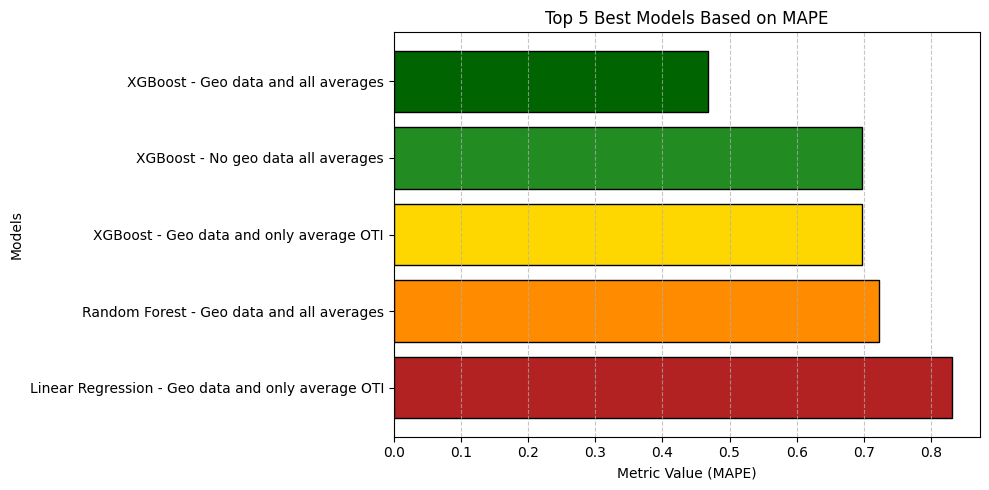

In [560]:
K: int = 5

best_results = results_flatten[ranking][:K]
best_models = ranked_models[:K]

colors = ['#006400', '#228B22', '#FFD700', '#FF8C00', '#B22222']

plt.figure(figsize=(10, 5))

plt.barh(best_models, best_results, color=colors, edgecolor='black', linewidth=1)
plt.xlabel(f'Metric Value ({METRIC_NAME})')
plt.ylabel('Models')
plt.title(f'Top {K} Best Models Based on {METRIC_NAME}')
plt.gca().invert_yaxis()                                            # Invert y-axis to show the best model at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, f'top_{K}_models_based_on_{METRIC_NAME}.png'))
plt.show()

## Iperamaters optimization

In [561]:
import optuna

def optimize_xgb(trial: optuna.Trial, 
                 X_train: np.ndarray, y_train: np.ndarray,
                 X_val: np.ndarray, y_val: np.ndarray, 
                 random_state: int = RANDOM_STATE) -> float:
    
    # Create the DMatrix for XGBoost
    dtrain = DMatrix(X_train, label=y_train)
    dval = DMatrix(X_val, label=y_val)

    params: Dict[str, Any] = {
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'eta': trial.suggest_float('eta', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 5.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 5.0, log=True),
        'seed': random_state,
        'verbosity': 0
    }

    # Train the model
    evals_result: Dict = {}
    model: Booster = xgb_train(
        params, 
        dtrain, 
        num_boost_round=1000, 
        evals=[(dval, "eval")], 
        early_stopping_rounds=50, 
        evals_result=evals_result,
        verbose_eval=False
    )
    preds = model.predict(dval)
    mae: float = MAE(y_val, preds)
    return mae

In [562]:
from scipy import stats

def compute_confidence_interval(data: np.ndarray, confidence: float = 0.95) -> Tuple[float, float, float]:
    n: int = len(data)
    mean: float = float(np.mean(data))
    std: float = float(np.std(data, ddof=1))  # sample standard deviation
    df: int = n - 1
    t_crit: float = float(stats.t.ppf(1 - (1 - confidence) / 2, df))
    margin_of_error: float = t_crit * (std / np.sqrt(n))
    ci_lower: float = mean - margin_of_error
    ci_upper: float = mean + margin_of_error
    return mean, ci_lower, ci_upper

compute_confidence_interval(np.array([1, 2, 3, 4, 5]))

(3.0, np.float64(1.036756838522439), np.float64(4.9632431614775605))

In [563]:
import xgboost as xgb
from sklearn.model_selection import KFold

def cross_validate_xgboost(X: np.ndarray, 
                           y: np.ndarray, 
                           X_augmented: np.ndarray,
                           y_augmented: np.ndarray,
                           params: Dict[str, Any], 
                           num_boost_round: int, 
                           n_splits: int = 10, 
                           ci_confidence: float = 0.95,
                           random_state: int = RANDOM_STATE,
                           use_augmented_data: bool = True
                           ) -> Tuple[pd.DataFrame, pd.DataFrame]:

    kf: KFold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Lists to store results
    fold_results: List[Dict[str, float]] = []

    for fold, (train_idx, val_idx) in tqdm(enumerate(kf.split(X), 1), total=n_splits):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        if use_augmented_data:
            X_tr = np.concatenate((X_tr, X_augmented), axis=0)
            y_tr = np.concatenate((y_tr, y_augmented), axis=0)

        # Convert to DMatrix
        dtrain: xgb.DMatrix = xgb.DMatrix(X_tr, label=y_tr)
        dval: xgb.DMatrix = xgb.DMatrix(X_val, label=y_val)

        # Train model
        model: xgb.Booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round
        )
        
        # Predictions
        y_pred: np.ndarray = model.predict(dval)

        # Compute metrics
        mae: float = MAE(y_val, y_pred)
        rmse: float = RMSE(y_val, y_pred)
        mape: float = MAPE(y_val, y_pred)

        fold_results.append({
            "Fold": fold,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        })
    
    df_results: pd.DataFrame = pd.DataFrame(fold_results)

    mae_ci: Tuple[float, float, float] = compute_confidence_interval(np.array(df_results['MAE'].values), ci_confidence)
    rmse_ci: Tuple[float, float, float] = compute_confidence_interval(np.array(df_results['RMSE'].values), ci_confidence)
    mape_ci: Tuple[float, float, float] = compute_confidence_interval(np.array(df_results['MAPE'].values), ci_confidence)

    summary = {
        "Folds": n_splits,
        "MAE_mean": df_results['MAE'].mean(),
        "MAE_std": df_results['MAE'].std(),
        "MAE_median": df_results['MAE'].median(),
        "MAE_CI_lower": mae_ci[1],
        "MAE_CI_upper": mae_ci[2],
        "RMSE_mean": df_results['RMSE'].mean(),
        "RMSE_std": df_results['RMSE'].std(),
        "RMSE_median": df_results['RMSE'].median(),
        "RMSE_CI_lower": rmse_ci[1],
        "RMSE_CI_upper": rmse_ci[2],
        "MAPE_mean": df_results['MAPE'].mean(),
        "MAPE_std": df_results['MAPE'].std(),
        "MAPE_median": df_results['MAPE'].median(),
        "MAPE_CI_lower": mape_ci[1],
        "MAPE_CI_upper": mape_ci[2]
    }
    df_summary: pd.DataFrame = pd.DataFrame([summary])

    return df_results, df_summary


In [612]:
N_SPLITS: int = 10
CONFIDENCE: float = 0.95

def cross_validate_baseline(
    X_all: np.ndarray,
    y_all: np.ndarray,
    n_splits: int,
    confidence: float = 0.95,
    random_state: int = RANDOM_STATE
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_results = []

    for fold, (_, val_idx) in tqdm(enumerate(kf.split(X_all), 1), total=n_splits):
        X_val = X_all[val_idx]
        y_val = y_all[val_idx]

        # Using last observation as "prediction"
        y_pred = X_val[:, -1]

        # Compute metrics
        mae = MAE(y_val, y_pred)
        rmse = RMSE(y_val, y_pred)
        mape = MAPE(y_val, y_pred)

        fold_results.append({
            "Fold": fold,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        })

    df_results = pd.DataFrame(fold_results)

    # Compute confidence intervals
    mae_ci = compute_confidence_interval(np.array(df_results['MAE'].values), confidence)
    rmse_ci = compute_confidence_interval(np.array(df_results['RMSE'].values), confidence)
    mape_ci = compute_confidence_interval(np.array(df_results['MAPE'].values), confidence)

    summary = {
        "Folds": n_splits,
        "MAE_mean": df_results['MAE'].mean(),
        "MAE_std": df_results['MAE'].std(),
        "MAE_median": df_results['MAE'].median(),
        "MAE_CI_lower": mae_ci[1],
        "MAE_CI_upper": mae_ci[2],
        "RMSE_mean": df_results['RMSE'].mean(),
        "RMSE_std": df_results['RMSE'].std(),
        "RMSE_median": df_results['RMSE'].median(),
        "RMSE_CI_lower": rmse_ci[1],
        "RMSE_CI_upper": rmse_ci[2],
        "MAPE_mean": df_results['MAPE'].mean(),
        "MAPE_std": df_results['MAPE'].std(),
        "MAPE_median": df_results['MAPE'].median(),
        "MAPE_CI_lower": mape_ci[1],
        "MAPE_CI_upper": mape_ci[2]
    }
    df_summary = pd.DataFrame([summary])

    return df_results, df_summary

### Geo data and only average oti

Only one augmentation iteration

#### Dataset preparation

In [564]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'wmi', 'tmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,wmi,tmi,avg_oti
0,61.761066,0.224436,0.0000,3.683333
1,9381.875452,0.750000,0.0000,18.966667
2,564.352543,0.101561,0.0000,1.983333
3,664.754853,0.119203,0.0000,1.860000
4,46.277438,0.103400,0.1484,0.944792


In [565]:
if AUGMENT_DATA:
    X_augmented_df: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'wmi', 'tmi', 'avg_oti', 'time']]
    y_augmented_series: pd.Series = X_augmented_df.pop('time')
else:
    X_augmented_df: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented_series: pd.Series = pd.Series(dtype=float)

X_augmented: np.ndarray = X_augmented_df.to_numpy()
y_augmented: np.ndarray = y_augmented_series.to_numpy()
print(X_augmented.shape, y_augmented.shape)

X_augmented_df.head()

(324, 4) (324,)


,distance,wmi,tmi,avg_oti
0,9443.636517,0.746563,0.000000,22.650000
1,9946.227995,0.713207,0.000000,20.950000
2,1229.107397,0.111102,0.000000,3.843333
3,711.032292,0.118174,0.009659,2.804792
4,62.925407,0.098869,0.172695,3.941667


In [566]:
splits: DataSplit = split_data(X, y)
trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (307, 4), X_val shape: (45, 4), X_test shape: (89, 4)


In [567]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (307,), Val set shape: (45,), Test set shape: (89,)


In [568]:
if AUGMENT_DATA:
    splits_augmented: DataSplit = concat_augmented_data(splits, X_augmented_df, y_augmented_series)
    trainable_splits_augmented: TrainableDataSplit = normalize_data(splits_augmented, normalize=False)
    X_train_aug: np.ndarray = trainable_splits_augmented.X_train
else:
    X_train_aug: np.ndarray = X_train.copy()

X_train_aug.shape


(631, 4)

In [569]:
y_train_aug: np.ndarray = trainable_splits_augmented.y_train
y_train_aug.shape

(631,)

##### Baseline CV

In [609]:
X_all: np.ndarray = np.concatenate([X_train, X_val, X_test])
y_all: np.ndarray = np.concatenate([y_train, y_val, y_test])

X_all.shape, y_all.shape

((765, 6), (765,))

In [614]:
folds_result_df, results_df = cross_validate_baseline(
    X_all,
    y_all,
    n_splits=N_SPLITS,
    confidence=CONFIDENCE
)

results_df

100%|██████████| 10/10 [00:00<00:00, 858.52it/s]


,Folds,MAE_mean,MAE_std,MAE_median,MAE_CI_lower,MAE_CI_upper,RMSE_mean,RMSE_std,RMSE_median,RMSE_CI_lower,RMSE_CI_upper,MAPE_mean,MAPE_std,MAPE_median,MAPE_CI_lower,MAPE_CI_upper
0,10,1.600352,0.283135,1.595443,1.397809,1.802895,3.575951,1.504191,2.984045,2.499918,4.651985,0.766022,0.258275,0.709286,0.581263,0.950781


#### Model

##### Iperamaters optimization:

In [570]:
study: optuna.Study = optuna.create_study(direction="minimize", study_name="XGBoost Hyperparameter Optimization")
study.optimize(lambda trial: optimize_xgb(trial, X_train_aug, y_train_aug, X_val, y_val), n_trials=200, timeout=60 * 5, n_jobs=-1)

print("Best trial:")
print(study.best_trial)

[I 2025-08-25 12:17:51,862] A new study created in memory with name: XGBoost Hyperparameter Optimization
[I 2025-08-25 12:17:52,203] Trial 2 finished with value: 0.9278831741489746 and parameters: {'max_depth': 12, 'min_child_weight': 11.751406834685431, 'gamma': 0.6099413035555394, 'eta': 0.3784439202295598, 'subsample': 0.9160206454862427, 'colsample_bytree': 0.6530350677612314, 'lambda': 3.704035041438992, 'alpha': 0.0040624966472263815}. Best is trial 2 with value: 0.9278831741489746.
[I 2025-08-25 12:17:52,215] Trial 3 finished with value: 1.1253835525998364 and parameters: {'max_depth': 8, 'min_child_weight': 1.5093135857124105, 'gamma': 0.48548481499033125, 'eta': 0.18384650511967396, 'subsample': 0.9365505041425216, 'colsample_bytree': 0.6495381287794312, 'lambda': 0.009045424395602231, 'alpha': 0.0012198004269515365}. Best is trial 2 with value: 0.9278831741489746.
[I 2025-08-25 12:17:52,256] Trial 5 finished with value: 0.9572315324456604 and parameters: {'max_depth': 15, 'mi

Best trial:
FrozenTrial(number=186, state=1, values=[0.7792251360747551], datetime_start=datetime.datetime(2025, 8, 25, 12, 18, 13, 993295), datetime_complete=datetime.datetime(2025, 8, 25, 12, 18, 14, 652733), params={'max_depth': 11, 'min_child_weight': 4.766394330378119, 'gamma': 0.907912443238618, 'eta': 0.3155496241621342, 'subsample': 0.9774798762218063, 'colsample_bytree': 0.7475894053301834, 'lambda': 0.00429911550090313, 'alpha': 2.0024336675948464}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=15, log=False, low=6, step=1), 'min_child_weight': FloatDistribution(high=15.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'eta': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'lambda': FloatDistribution(hi

In [571]:
default_params: Dict[str, Any] = XGB_DEFAULT_PARAMS
default_params['seed'] = RANDOM_STATE

default_params

{'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'max_depth': 8,
 'min_child_weight': 3,
 'gamma': 0.1,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'lambda': 0.1,
 'alpha': 0.0,
 'seed': 23}

In [572]:
best_params: Dict[str, Any] = study.best_trial.params
best_params.update({
    'objective': 'reg:absoluteerror',
    'booster': 'gbtree',
    'seed': RANDOM_STATE
})

best_params

{'max_depth': 11,
 'min_child_weight': 4.766394330378119,
 'gamma': 0.907912443238618,
 'eta': 0.3155496241621342,
 'subsample': 0.9774798762218063,
 'colsample_bytree': 0.7475894053301834,
 'lambda': 0.00429911550090313,
 'alpha': 2.0024336675948464,
 'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'seed': 23}

In [573]:
best_iterations: int = study.best_trial.number
X_all: np.ndarray = np.concatenate([X_train, X_val, X_test])
y_all: np.ndarray = np.concatenate([y_train, y_val, y_test])

best_iterations, len(X_all), len(y_all), len(X_augmented), len(y_augmented)

(186, 441, 441, 324, 324)

##### Cross validation

Default params:

In [574]:
folds_result_df, results_df = cross_validate_xgboost(X=X_all, 
                                                     y=y_all, 
                                                     X_augmented=X_augmented,
                                                     y_augmented=y_augmented,
                                                     params=default_params, 
                                                     num_boost_round=best_iterations, 
                                                     n_splits=10, 
                                                     random_state=RANDOM_STATE, 
                                                     use_augmented_data=True)

results_df

100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


,Folds,MAE_mean,MAE_std,MAE_median,MAE_CI_lower,MAE_CI_upper,RMSE_mean,RMSE_std,RMSE_median,RMSE_CI_lower,RMSE_CI_upper,MAPE_mean,MAPE_std,MAPE_median,MAPE_CI_lower,MAPE_CI_upper
0,10,1.135411,0.576479,0.926749,0.723023,1.5478,3.014881,2.624903,1.899674,1.137138,4.892624,0.54286,0.282552,0.421488,0.340735,0.744986


Optimized params:

In [575]:
folds_result_df, results_df = cross_validate_xgboost(X=X_all, 
                                                     y=y_all, 
                                                     X_augmented=X_augmented,
                                                     y_augmented=y_augmented,
                                                     params=best_params, 
                                                     num_boost_round=best_iterations, 
                                                     n_splits=10, 
                                                     random_state=RANDOM_STATE, 
                                                     use_augmented_data=True)

results_df

100%|██████████| 10/10 [00:00<00:00, 10.03it/s]


,Folds,MAE_mean,MAE_std,MAE_median,MAE_CI_lower,MAE_CI_upper,RMSE_mean,RMSE_std,RMSE_median,RMSE_CI_lower,RMSE_CI_upper,MAPE_mean,MAPE_std,MAPE_median,MAPE_CI_lower,MAPE_CI_upper
0,10,1.179942,0.569417,0.976044,0.772606,1.587278,2.92879,2.308665,2.038689,1.277271,4.580309,0.582233,0.332151,0.432618,0.344627,0.81984


### No geo data and all averages

One augmentation iteration

#### Dataset preparation

In [576]:
X: pd.DataFrame = routes_df.loc[:, ['wmi', 'avg_wmi', 'tmi', 'avg_tmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,wmi,avg_wmi,tmi,avg_tmi,avg_oti
0,0.224436,0.224436,0.0000,0.000000,3.683333
1,0.750000,0.750000,0.0000,0.000000,18.966667
2,0.101561,0.101561,0.0000,0.000000,1.983333
3,0.119203,0.231342,0.0000,0.000000,1.860000
4,0.103400,0.106983,0.1484,0.093648,0.944792


In [577]:
if AUGMENT_DATA:
    X_augmented_df: pd.DataFrame = first_level_augmented_routes_df.loc[:, ['wmi', 'avg_wmi', 'tmi', 'avg_tmi', 'avg_oti', 'time']]
    y_augmented_series: pd.Series = X_augmented_df.pop('time')
else:
    X_augmented_df: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented_series: pd.Series = pd.Series(dtype=float)

X_augmented: np.ndarray = X_augmented_df.to_numpy()
y_augmented: np.ndarray = y_augmented_series.to_numpy()
print(X_augmented.shape, y_augmented.shape)

X_augmented_df.head()

(324, 5) (324,)


,wmi,avg_wmi,tmi,avg_tmi,avg_oti
0,0.746563,0.746563,0.000000,0.000000,22.650000
1,0.713207,0.713207,0.000000,0.000000,20.950000
2,0.111102,0.171752,0.000000,0.000000,3.843333
3,0.118174,0.223248,0.009659,0.006095,2.804792
4,0.098869,0.078679,0.172695,0.068872,3.941667


In [578]:
splits: DataSplit = split_data(X, y)
trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (307, 5), X_val shape: (45, 5), X_test shape: (89, 5)


In [579]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (307,), Val set shape: (45,), Test set shape: (89,)


In [580]:
if AUGMENT_DATA:
    splits_augmented: DataSplit = concat_augmented_data(splits, X_augmented_df, y_augmented_series)
    trainable_splits_augmented: TrainableDataSplit = normalize_data(splits_augmented, normalize=False)
    X_train_aug: np.ndarray = trainable_splits_augmented.X_train
else:
    X_train_aug: np.ndarray = X_train.copy()

X_train_aug.shape


(631, 5)

In [581]:
y_train_aug: np.ndarray = trainable_splits_augmented.y_train
y_train_aug.shape

(631,)

#### Model

##### Iperamaters optimization:

In [582]:
study: optuna.Study = optuna.create_study(direction="minimize", study_name="XGBoost Hyperparameter Optimization")
study.optimize(lambda trial: optimize_xgb(trial, X_train_aug, y_train_aug, X_val, y_val), n_trials=200, timeout=60 * 5, n_jobs=-1)

print("Best trial:")
print(study.best_trial)

[I 2025-08-25 12:18:18,590] A new study created in memory with name: XGBoost Hyperparameter Optimization
[I 2025-08-25 12:18:19,010] Trial 2 finished with value: 0.915381929786117 and parameters: {'max_depth': 13, 'min_child_weight': 14.729276715422776, 'gamma': 0.8391246485135152, 'eta': 0.22910717673093767, 'subsample': 0.8878404096821255, 'colsample_bytree': 0.8121256318163436, 'lambda': 0.3603238643690369, 'alpha': 0.014892665712322324}. Best is trial 2 with value: 0.915381929786117.
[I 2025-08-25 12:18:19,033] Trial 7 finished with value: 1.106006074707817 and parameters: {'max_depth': 14, 'min_child_weight': 5.268479643091742, 'gamma': 0.2634205539616814, 'eta': 0.40822382135622054, 'subsample': 0.6373799001132362, 'colsample_bytree': 0.7882031581293892, 'lambda': 2.8290919747603285, 'alpha': 0.03813371574005175}. Best is trial 2 with value: 0.915381929786117.
[I 2025-08-25 12:18:19,254] Trial 5 finished with value: 1.0412782282299466 and parameters: {'max_depth': 9, 'min_child_w

Best trial:
FrozenTrial(number=138, state=1, values=[0.809824158207134], datetime_start=datetime.datetime(2025, 8, 25, 12, 18, 34, 243397), datetime_complete=datetime.datetime(2025, 8, 25, 12, 18, 35, 393569), params={'max_depth': 13, 'min_child_weight': 11.808529656060777, 'gamma': 0.632620521072744, 'eta': 0.28048519587702403, 'subsample': 0.9014997892273408, 'colsample_bytree': 0.716380669743088, 'lambda': 0.005410476874446271, 'alpha': 0.09695466216067973}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=15, log=False, low=6, step=1), 'min_child_weight': FloatDistribution(high=15.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'eta': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'lambda': FloatDistribution(

In [583]:
default_params: Dict[str, Any] = XGB_DEFAULT_PARAMS
default_params['seed'] = RANDOM_STATE

default_params

{'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'max_depth': 8,
 'min_child_weight': 3,
 'gamma': 0.1,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'lambda': 0.1,
 'alpha': 0.0,
 'seed': 23}

In [584]:
best_params: Dict[str, Any] = study.best_trial.params
best_params.update({
    'objective': 'reg:absoluteerror',
    'booster': 'gbtree',
    'seed': RANDOM_STATE
})

best_params

{'max_depth': 13,
 'min_child_weight': 11.808529656060777,
 'gamma': 0.632620521072744,
 'eta': 0.28048519587702403,
 'subsample': 0.9014997892273408,
 'colsample_bytree': 0.716380669743088,
 'lambda': 0.005410476874446271,
 'alpha': 0.09695466216067973,
 'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'seed': 23}

In [585]:
best_iterations: int = study.best_trial.number
X_all: np.ndarray = np.concatenate([X_train, X_val, X_test])
y_all: np.ndarray = np.concatenate([y_train, y_val, y_test])

best_iterations, len(X_all), len(y_all), len(X_augmented), len(y_augmented)

(138, 441, 441, 324, 324)

##### Cross validation

Default params:

In [586]:
folds_result_df, results_df = cross_validate_xgboost(X=X_all, 
                                                     y=y_all, 
                                                     X_augmented=X_augmented,
                                                     y_augmented=y_augmented,
                                                     params=default_params, 
                                                     num_boost_round=best_iterations, 
                                                     n_splits=10, 
                                                     random_state=RANDOM_STATE, 
                                                     use_augmented_data=True)

results_df

100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


,Folds,MAE_mean,MAE_std,MAE_median,MAE_CI_lower,MAE_CI_upper,RMSE_mean,RMSE_std,RMSE_median,RMSE_CI_lower,RMSE_CI_upper,MAPE_mean,MAPE_std,MAPE_median,MAPE_CI_lower,MAPE_CI_upper
0,10,1.092448,0.56471,0.921953,0.688479,1.496417,2.83674,2.741061,1.853849,0.875903,4.797577,0.47199,0.222937,0.387905,0.312511,0.631469


Optimized params:

In [587]:
folds_result_df, results_df = cross_validate_xgboost(X=X_all, 
                                                     y=y_all, 
                                                     X_augmented=X_augmented,
                                                     y_augmented=y_augmented,
                                                     params=best_params, 
                                                     num_boost_round=best_iterations, 
                                                     n_splits=10, 
                                                     random_state=RANDOM_STATE, 
                                                     use_augmented_data=True)

results_df

100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


,Folds,MAE_mean,MAE_std,MAE_median,MAE_CI_lower,MAE_CI_upper,RMSE_mean,RMSE_std,RMSE_median,RMSE_CI_lower,RMSE_CI_upper,MAPE_mean,MAPE_std,MAPE_median,MAPE_CI_lower,MAPE_CI_upper
0,10,1.100834,0.559107,0.933013,0.700873,1.500795,2.792627,2.811007,1.795202,0.781754,4.8035,0.538942,0.205684,0.561519,0.391804,0.686079


### Geo data and all averages

One augmentation iteration

#### Dataset preparation

In [588]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'wmi', 'avg_wmi', 'tmi', 'avg_tmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,wmi,avg_wmi,tmi,avg_tmi,avg_oti
0,61.761066,0.224436,0.224436,0.0000,0.000000,3.683333
1,9381.875452,0.750000,0.750000,0.0000,0.000000,18.966667
2,564.352543,0.101561,0.101561,0.0000,0.000000,1.983333
3,664.754853,0.119203,0.231342,0.0000,0.000000,1.860000
4,46.277438,0.103400,0.106983,0.1484,0.093648,0.944792


In [589]:
if AUGMENT_DATA:
    X_augmented_df: pd.DataFrame = first_level_augmented_routes_df.loc[:, ['distance', 'wmi', 'avg_wmi', 'tmi', 'avg_tmi', 'avg_oti', 'time']]
    y_augmented_series: pd.Series = X_augmented_df.pop('time')
else:
    X_augmented_df: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented_series: pd.Series = pd.Series(dtype=float)

X_augmented: np.ndarray = X_augmented_df.to_numpy()
y_augmented: np.ndarray = y_augmented_series.to_numpy()
print(X_augmented.shape, y_augmented.shape)

X_augmented_df.head()

(324, 6) (324,)


,distance,wmi,avg_wmi,tmi,avg_tmi,avg_oti
0,9443.636517,0.746563,0.746563,0.000000,0.000000,22.650000
1,9946.227995,0.713207,0.713207,0.000000,0.000000,20.950000
2,1229.107397,0.111102,0.171752,0.000000,0.000000,3.843333
3,711.032292,0.118174,0.223248,0.009659,0.006095,2.804792
4,62.925407,0.098869,0.078679,0.172695,0.068872,3.941667


In [590]:
splits: DataSplit = split_data(X, y)
trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (307, 6), X_val shape: (45, 6), X_test shape: (89, 6)


In [591]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (307,), Val set shape: (45,), Test set shape: (89,)


In [592]:
if AUGMENT_DATA:
    splits_augmented: DataSplit = concat_augmented_data(splits, X_augmented_df, y_augmented_series)
    trainable_splits_augmented: TrainableDataSplit = normalize_data(splits_augmented, normalize=False)
    X_train_aug: np.ndarray = trainable_splits_augmented.X_train
else:
    X_train_aug: np.ndarray = X_train.copy()

X_train_aug.shape


(631, 6)

In [593]:
y_train_aug: np.ndarray = trainable_splits_augmented.y_train
y_train_aug.shape

(631,)

#### Model

##### Iperamaters optimization:

In [594]:
study: optuna.Study = optuna.create_study(direction="minimize", study_name="XGBoost Hyperparameter Optimization")
study.optimize(lambda trial: optimize_xgb(trial, X_train_aug, y_train_aug, X_val, y_val), n_trials=200, timeout=60 * 5, n_jobs=-1)

print("Best trial:")
print(study.best_trial)

[I 2025-08-25 12:18:47,144] A new study created in memory with name: XGBoost Hyperparameter Optimization
[I 2025-08-25 12:18:47,624] Trial 6 finished with value: 1.042274184536051 and parameters: {'max_depth': 6, 'min_child_weight': 1.1826393173451952, 'gamma': 0.058538598329210156, 'eta': 0.2875729545368814, 'subsample': 0.7978914312061046, 'colsample_bytree': 0.8441435742122176, 'lambda': 1.1679646643539916, 'alpha': 1.0757604920291053}. Best is trial 6 with value: 1.042274184536051.
[I 2025-08-25 12:18:47,650] Trial 2 finished with value: 1.0003799337479804 and parameters: {'max_depth': 9, 'min_child_weight': 8.88495929055016, 'gamma': 0.7634937679533573, 'eta': 0.18397701801482808, 'subsample': 0.7569868594114966, 'colsample_bytree': 0.6979340616189889, 'lambda': 0.0013356094502741953, 'alpha': 4.154802094025342}. Best is trial 2 with value: 1.0003799337479804.
[I 2025-08-25 12:18:47,678] Trial 3 finished with value: 1.0082101513583352 and parameters: {'max_depth': 14, 'min_child_w

Best trial:
FrozenTrial(number=193, state=1, values=[0.8920600186453926], datetime_start=datetime.datetime(2025, 8, 25, 12, 19, 24, 719837), datetime_complete=datetime.datetime(2025, 8, 25, 12, 19, 27, 37038), params={'max_depth': 14, 'min_child_weight': 6.4223356690126305, 'gamma': 0.1720344034319662, 'eta': 0.01079546113706563, 'subsample': 0.99892633669137, 'colsample_bytree': 0.9664555216838384, 'lambda': 1.6106475048266382, 'alpha': 1.374036653642356}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=15, log=False, low=6, step=1), 'min_child_weight': FloatDistribution(high=15.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'eta': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'lambda': FloatDistribution(high

In [595]:
default_params: Dict[str, Any] = XGB_DEFAULT_PARAMS
default_params['seed'] = RANDOM_STATE

default_params

{'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'max_depth': 8,
 'min_child_weight': 3,
 'gamma': 0.1,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'lambda': 0.1,
 'alpha': 0.0,
 'seed': 23}

In [596]:
best_params: Dict[str, Any] = study.best_trial.params
best_params.update({
    'objective': 'reg:absoluteerror',
    'booster': 'gbtree',
    'seed': RANDOM_STATE
})

best_params

{'max_depth': 14,
 'min_child_weight': 6.4223356690126305,
 'gamma': 0.1720344034319662,
 'eta': 0.01079546113706563,
 'subsample': 0.99892633669137,
 'colsample_bytree': 0.9664555216838384,
 'lambda': 1.6106475048266382,
 'alpha': 1.374036653642356,
 'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'seed': 23}

In [597]:
best_iterations: int = study.best_trial.number
X_all: np.ndarray = np.concatenate([X_train, X_val, X_test])
y_all: np.ndarray = np.concatenate([y_train, y_val, y_test])

best_iterations, len(X_all), len(y_all), len(X_augmented), len(y_augmented)

(193, 441, 441, 324, 324)

##### Cross validation

Default params:

In [598]:
folds_result_df, results_df = cross_validate_xgboost(X=X_all, 
                                                     y=y_all, 
                                                     X_augmented=X_augmented,
                                                     y_augmented=y_augmented,
                                                     params=default_params, 
                                                     num_boost_round=best_iterations, 
                                                     n_splits=10, 
                                                     random_state=RANDOM_STATE, 
                                                     use_augmented_data=True)

results_df

100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


,Folds,MAE_mean,MAE_std,MAE_median,MAE_CI_lower,MAE_CI_upper,RMSE_mean,RMSE_std,RMSE_median,RMSE_CI_lower,RMSE_CI_upper,MAPE_mean,MAPE_std,MAPE_median,MAPE_CI_lower,MAPE_CI_upper
0,10,1.117012,0.579531,0.89689,0.702441,1.531583,3.013517,2.843884,1.940083,0.979125,5.047909,0.443757,0.169643,0.36849,0.322401,0.565112


Optimized params:

In [599]:
folds_result_df, results_df = cross_validate_xgboost(X=X_all, 
                                                     y=y_all, 
                                                     X_augmented=X_augmented,
                                                     y_augmented=y_augmented,
                                                     params=best_params, 
                                                     num_boost_round=best_iterations, 
                                                     n_splits=10, 
                                                     random_state=RANDOM_STATE, 
                                                     use_augmented_data=True)

results_df

100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


,Folds,MAE_mean,MAE_std,MAE_median,MAE_CI_lower,MAE_CI_upper,RMSE_mean,RMSE_std,RMSE_median,RMSE_CI_lower,RMSE_CI_upper,MAPE_mean,MAPE_std,MAPE_median,MAPE_CI_lower,MAPE_CI_upper
0,10,1.372481,0.57052,1.339564,0.964356,1.780607,3.153056,2.785205,2.557403,1.16064,5.145472,2.012823,0.966543,2.015017,1.3214,2.704246


### Final model

#### Dataset preparation

In [600]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,61.761066,0.0000,0.000000,0.224436,0.224436,3.683333
1,9381.875452,0.0000,0.000000,0.750000,0.750000,18.966667
2,564.352543,0.0000,0.000000,0.101561,0.101561,1.983333
3,664.754853,0.0000,0.000000,0.119203,0.231342,1.860000
4,46.277438,0.1484,0.093648,0.103400,0.106983,0.944792


In [601]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,9443.636517,0.000000,0.000000,0.746563,0.746563,22.650000
1,9946.227995,0.000000,0.000000,0.713207,0.713207,20.950000
2,1229.107397,0.000000,0.000000,0.111102,0.171752,3.843333
3,711.032292,0.009659,0.006095,0.118174,0.223248,2.804792
4,62.925407,0.172695,0.068872,0.098869,0.078679,3.941667


In [602]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (631, 6), X_val shape: (45, 6), X_test shape: (89, 6)


In [603]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (631,), Val set shape: (45,), Test set shape: (89,)


#### Model

In [604]:
xgb_final: Booster = train_xgb(X_train, y_train, X_val, y_val, random_state=RANDOM_STATE)

best_score: float = xgb_final.best_score
best_iterations: int = xgb_final.best_iteration

xgb_final, xgb_final.best_score, best_iterations

[0]	eval-mae:2.77291
[1]	eval-mae:2.53936
[2]	eval-mae:2.30999
[3]	eval-mae:2.10994
[4]	eval-mae:1.88690
[5]	eval-mae:1.74565
[6]	eval-mae:1.58743
[7]	eval-mae:1.47136
[8]	eval-mae:1.38464
[9]	eval-mae:1.32015
[10]	eval-mae:1.26877
[11]	eval-mae:1.22700
[12]	eval-mae:1.19601
[13]	eval-mae:1.16520
[14]	eval-mae:1.13597
[15]	eval-mae:1.12463
[16]	eval-mae:1.12483
[17]	eval-mae:1.10257
[18]	eval-mae:1.07448
[19]	eval-mae:1.08606
[20]	eval-mae:1.07359
[21]	eval-mae:1.06991
[22]	eval-mae:1.06302
[23]	eval-mae:1.05769
[24]	eval-mae:1.04294
[25]	eval-mae:1.03645
[26]	eval-mae:1.04019
[27]	eval-mae:1.03825
[28]	eval-mae:1.02907
[29]	eval-mae:1.02902
[30]	eval-mae:1.02708
[31]	eval-mae:1.01925
[32]	eval-mae:1.01571
[33]	eval-mae:1.01805
[34]	eval-mae:1.01659
[35]	eval-mae:1.02998
[36]	eval-mae:1.02810
[37]	eval-mae:1.02818
[38]	eval-mae:1.03302
[39]	eval-mae:1.03208
[40]	eval-mae:1.03177
[41]	eval-mae:1.03248
[42]	eval-mae:1.02265
[43]	eval-mae:1.02320
[44]	eval-mae:1.02500
[45]	eval-mae:1.0268

(<xgboost.core.Booster at 0x2d76f559180>, 1.015706053045061, 32)

In [605]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred = xgb_final.predict(dtest)

xgb_eval: EvaluationResult = evaluate_model(y_test, y_pred, XGB_MODEL_NAME, "Geo data and only average OTI")


XGBoost Results:
MAE: 0.9002
RMSE: 1.6189
MAPE: 0.4673
MSDP: 0.3141


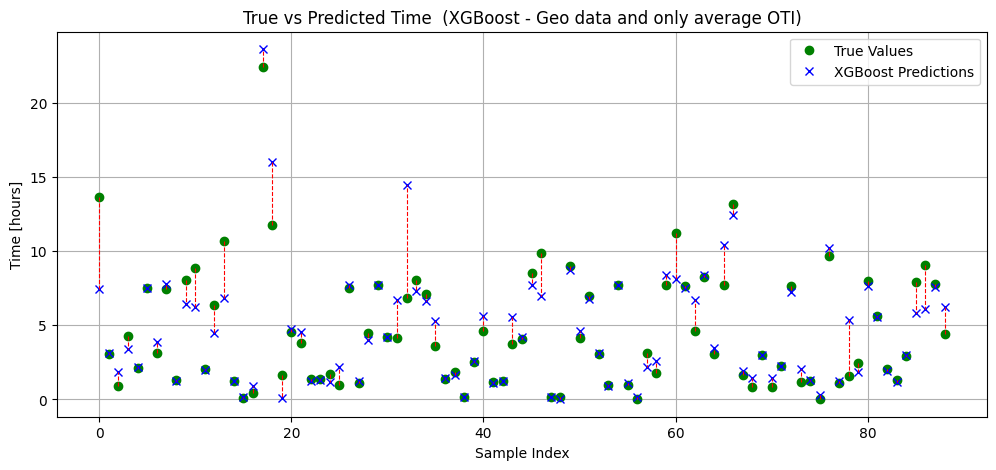

In [606]:
plot_predictions(y_test, y_pred, XGB_MODEL_NAME, "Geo data and only average OTI")

In [607]:
xgb_final.save_model(os.path.join(MODEL_PATH, f"rt_estimator_{XGB_MODEL_NAME.lower()}.json"))

In [608]:
import xgboost as xgb 

with open(os.path.join(MODEL_PATH, f"rt_estimator_{XGB_MODEL_NAME.lower()}.json"), 'r') as f:
    model_json_str = f.read()

# Create booster and load directly from the JSON string
booster = xgb.Booster()
booster.load_model(bytearray(model_json_str, 'utf-8'))

booster